Start date: 5/20/2020

#### Importing objects and functions

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.table import QTable, Table, Column
from astropy import units as u
from astropy.io import ascii
from scipy.optimize import curve_fit

In [201]:
mangaHI = Table.read("out_txt/GBT_HI_with_MStar.txt", format="ascii.commented_header")
alfaHI =  Table.read("out_txt/ALFALFA_HI_with_MStar.txt", format="ascii.commented_header")
table2 = Table.read("input/Pipe3D-master_file_vflag_10_smooth2p27_N2O2_noWords.txt", format="ascii.commented_header")

In [202]:
wp20_manga = mangaHI["WP20"]
wf50_manga = mangaHI["WF50"]
wp50_manga = mangaHI["WP50"]

In [203]:
wp20_alfa = alfaHI["WP20"]
wf50_alfa = alfaHI["WF50"]

In [204]:
mangaHI

mangaid,objra,objdec,vopt,session,Exp,rms,logHIlim200kms,peak,snr,FHI,logMHI,VHI,eV,WM50,WP50,WP20,W2P50,WF50,Pr,Pl,ar,br,al,bl,MStar,logMStar,Plate,IFU
str9,float64,float64,int32,str12,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32
1-604053,50.6967861,0.14936614,6845,16A-2,697.5,1.5099999904632568,-999.0,28.020000457763672,18.5,4.670000076293945,10.039999961853027,6859,5.25,236,215,243,216,221,25.510000228881836,28.020000457763672,118.3499984741211,0.9599999785423279,82.83000183105469,-0.6299999952316284,24294725632.0,10.385511998802142,8083,12704
1-38173,49.9732257,0.39144219,7148,16A-2,538.2000122070312,2.059999942779541,-999.0,9.279999732971191,4.0,1.3700000047683716,9.539999961853027,7062,150.77999877929688,438,257,438,193,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2329206272.0,9.367207950889586,8083,3702
1-24145,258.8469457,57.43288135,9653,16A-2,897.0,1.5800000429153442,9.170000076293945,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999,-999,-999,-999,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,123334836224.0,11.091085761453927,7991,12702
1-24368,261.3210536,56.95187738,7496,16A-2,897.0999755859375,1.5399999618530273,-999.0,7.260000228881836,4.699999809265137,0.9599999785423279,9.430000305175781,7497,22.520000457763672,238,212,244,229,225,7.260000228881836,6.630000114440918,20.969999313354492,0.1599999964237213,8.84000015258789,-0.05999999865889549,5400114176.0,9.73240294231974,7991,12704
1-23979,258.1587518,57.32242143,7983,16A-2,568.2000122070312,1.690000057220459,9.029999732971191,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999,-999,-999,-999,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,10823595008.0,10.034371533674436,7991,3702
1-24124,258.5302615,57.47743353,8049,16A-2,618.0999755859375,1.600000023841858,9.020000457763672,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999,-999,-999,-999,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2872524800.0,9.458263786866556,7991,3703
1-23891,260.2282152,57.09795578,8234,16A-2-17,1256.0999755859375,1.3300000429153442,-999.0,5.900000095367432,4.400000095367432,0.5799999833106995,9.279999732971191,8099,38.41999816894531,200,150,201,155,155,3.950000047683716,5.900000095367432,16.8700008392334,0.20000000298023224,4.619999885559082,-0.029999999329447746,18465875968.0,10.266369914155716,7991,3704
1-37998,50.1888814,-1.05394485,6233,16A-3,707.0999755859375,1.2999999523162842,-999.0,21.200000762939453,17.100000381469727,5.659999847412109,10.050000190734863,6295,4.110000133514404,380,312,383,326,333,16.270000457763672,22.200000762939453,56.970001220703125,0.30000001192092896,41.4900016784668,-0.1899999976158142,6834482176.0,9.8347056152279,8082,3703
1-37965,48.6427236,0.53237488,6293,16A-3,647.4000244140625,1.2999999523162842,-999.0,6.539999961853027,5.0,0.4699999988079071,8.970000267028809,6305,11.600000381469727,110,92,109,92,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1326035712.0,9.122555220385262,8082,9101


#### Separating voids and walls using their vflag values

##### GBT

In [205]:
#Adding vflag column to mangaHI table in the right corresponding positions by matching the Plate and IFU numbers of the galaxies

vflag_manga = []
for i in range(len(mangaHI)):
    for j in range(len(table2)):
        if (table2['MaNGA_plate'][j], table2['MaNGA_IFU'][j]) == (mangaHI['Plate'][i], mangaHI['IFU'][i]):
            vflag_manga.append(table2['vflag'][j])
vflag_manga_col = Column(np.asarray(vflag_manga, dtype = np.float64, order = 'F'), name = 'vflag')
#mangaHI.remove_column('vflag')
mangaHI.add_column(vflag_manga_col)

In [206]:
#Separating voids and walls using vflag values in mangaHI table. vflag of 1.0 are voids and vflag of 0.0 are walls. 
#When the vflag column has a value of 1.0 add the MStar of that row to the vflag column and do the same for walls

voids_manga = []
walls_manga = []

for i in range(len(mangaHI)):
    if mangaHI['vflag'][i] == 1.0:
        voids_manga.append(mangaHI['MStar'][i])
        walls_manga.append(-999.0)
    elif mangaHI['vflag'][i] == 0.0:
        walls_manga.append(mangaHI['MStar'][i])
        voids_manga.append(-999.0)
    else: 
        voids_manga.append(-999.0)
        walls_manga.append(-999.0)
        
voids_manga_col = Column(np.asarray(voids_manga, dtype = np.float64, order = 'F'), name = 'Voids')
walls_manga_col = Column(np.asarray(walls_manga, dtype = np.float64, order = 'F'), name = 'Walls')
#mangaHI.remove_column('Voids')
#mangaHI.remove_column('Walls')
mangaHI.add_column(voids_manga_col)
mangaHI.add_column(walls_manga_col)

##### ALFALFA

In [207]:
#Adding vflag column to alfaHI table in the right corresponding positions by matching the Plate and IFU numbers of the galaxies

vflag_alfa = []
for i in range(len(alfaHI)):
    for j in range(len(table2)):
        if (table2['MaNGA_plate'][j], table2['MaNGA_IFU'][j]) == (alfaHI['Plate'][i], alfaHI['IFU'][i]):
            vflag_alfa.append(table2['vflag'][j])
vflag_alfa_col = Column(np.asarray(vflag_alfa, dtype = np.float64, order = 'F'), name = 'vflag')
#alfaHI.remove_column('vflag')
alfaHI.add_column(vflag_alfa_col)

In [208]:
#Separating voids and walls using vflag values in alfaHI table. vflag of 1.0 are voids and vflag of 0.0 are walls. 
#When the vflag column has a value of 1.0 add the MStar of that row to the vflag column and do the same for walls

voids_alfa = []
walls_alfa = []

for i in range(len(alfaHI)):
    if alfaHI['vflag'][i] == 1.0:
        voids_alfa.append(alfaHI['MStar'][i])
        walls_alfa.append(-999.0)
    elif alfaHI['vflag'][i] == 0.0:
        walls_alfa.append(alfaHI['MStar'][i])
        voids_alfa.append(-999.0)
    else: 
        voids_alfa.append(-999.0)
        walls_alfa.append(-999.0)
        
voids_alfa_col = Column(np.asarray(voids_alfa, dtype = np.float64, order = 'F'), name = 'Voids')
walls_alfa_col = Column(np.asarray(walls_alfa, dtype = np.float64, order = 'F'), name = 'Walls')
#alfaHI.remove_column('Voids')
#alfaHI.remove_column('Walls')
alfaHI.add_column(voids_alfa_col)
alfaHI.add_column(walls_alfa_col)

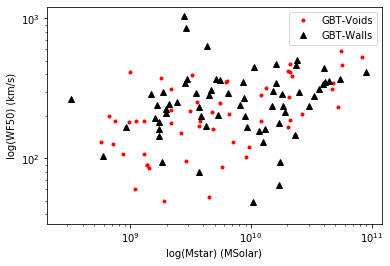

In [209]:
#Plot of log(WF50) vs log(MStar) for voids and walls of GBT data

plt.loglog(mangaHI['Voids'], wf50_manga, '.', label = 'GBT-Voids', color = 'red')
plt.loglog(mangaHI['Walls'], wf50_manga, '^', label = 'GBT-Walls', color = 'black')
plt.ylabel('log(WF50) (km/s)')
plt.xlabel('log(Mstar) (MSolar)')
plt.legend()
plt.savefig('plots/GBT_WF50-log_Mstar_VoidsAndWalls.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.show()

In [210]:
mangaHI

mangaid,objra,objdec,vopt,session,Exp,rms,logHIlim200kms,peak,snr,FHI,logMHI,VHI,eV,WM50,WP50,WP20,W2P50,WF50,Pr,Pl,ar,br,al,bl,MStar,logMStar,Plate,IFU,vflag,Voids,Walls
str9,float64,float64,int32,str12,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64
1-604053,50.6967861,0.14936614,6845,16A-2,697.5,1.5099999904632568,-999.0,28.020000457763672,18.5,4.670000076293945,10.039999961853027,6859,5.25,236,215,243,216,221,25.510000228881836,28.020000457763672,118.3499984741211,0.9599999785423279,82.83000183105469,-0.6299999952316284,24294725632.0,10.385511998802142,8083,12704,-9.0,-999.0,-999.0
1-38173,49.9732257,0.39144219,7148,16A-2,538.2000122070312,2.059999942779541,-999.0,9.279999732971191,4.0,1.3700000047683716,9.539999961853027,7062,150.77999877929688,438,257,438,193,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2329206272.0,9.367207950889586,8083,3702,-9.0,-999.0,-999.0
1-24145,258.8469457,57.43288135,9653,16A-2,897.0,1.5800000429153442,9.170000076293945,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999,-999,-999,-999,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,123334836224.0,11.091085761453927,7991,12702,-9.0,-999.0,-999.0
1-24368,261.3210536,56.95187738,7496,16A-2,897.0999755859375,1.5399999618530273,-999.0,7.260000228881836,4.699999809265137,0.9599999785423279,9.430000305175781,7497,22.520000457763672,238,212,244,229,225,7.260000228881836,6.630000114440918,20.969999313354492,0.1599999964237213,8.84000015258789,-0.05999999865889549,5400114176.0,9.73240294231974,7991,12704,-9.0,-999.0,-999.0
1-23979,258.1587518,57.32242143,7983,16A-2,568.2000122070312,1.690000057220459,9.029999732971191,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999,-999,-999,-999,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,10823595008.0,10.034371533674436,7991,3702,-9.0,-999.0,-999.0
1-24124,258.5302615,57.47743353,8049,16A-2,618.0999755859375,1.600000023841858,9.020000457763672,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999,-999,-999,-999,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2872524800.0,9.458263786866556,7991,3703,-9.0,-999.0,-999.0
1-23891,260.2282152,57.09795578,8234,16A-2-17,1256.0999755859375,1.3300000429153442,-999.0,5.900000095367432,4.400000095367432,0.5799999833106995,9.279999732971191,8099,38.41999816894531,200,150,201,155,155,3.950000047683716,5.900000095367432,16.8700008392334,0.20000000298023224,4.619999885559082,-0.029999999329447746,18465875968.0,10.266369914155716,7991,3704,-9.0,-999.0,-999.0
1-37998,50.1888814,-1.05394485,6233,16A-3,707.0999755859375,1.2999999523162842,-999.0,21.200000762939453,17.100000381469727,5.659999847412109,10.050000190734863,6295,4.110000133514404,380,312,383,326,333,16.270000457763672,22.200000762939453,56.970001220703125,0.30000001192092896,41.4900016784668,-0.1899999976158142,6834482176.0,9.8347056152279,8082,3703,-9.0,-999.0,-999.0
1-37965,48.6427236,0.53237488,6293,16A-3,647.4000244140625,1.2999999523162842,-999.0,6.539999961853027,5.0,0.4699999988079071,8.970000267028809,6305,11.600000381469727,110,92,109,92,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1326035712.0,9.122555220385262,8082,9101,-9.0,-999.0,-999.0


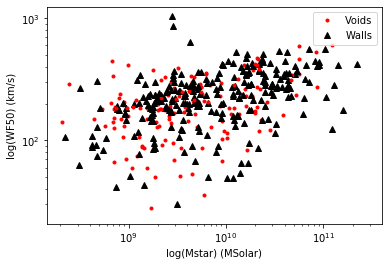

In [211]:
#Plot of log(WF50) vs log(MStar) for voids and walls of GBT & ALFALFA data

plt.loglog(alfaHI['Voids'], wf50_alfa, '.', label = 'Voids', color = 'red')
plt.loglog(alfaHI['Walls'], wf50_alfa, '^', label = 'Walls', color = 'black')
plt.loglog(mangaHI['Voids'], wf50_manga, '.', color = 'red')
plt.loglog(mangaHI['Walls'], wf50_manga, '^', color = 'black')
plt.ylabel('log(WF50) (km/s)')
plt.xlabel('log(Mstar) (MSolar)')
plt.legend()
plt.savefig('plots/WF50-log_Mstar_VoidsAndWalls.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.show()

In [212]:
mangaHI.write('out_txt/MaNGA_with_voids&walls_classified.txt', format = 'ascii.commented_header', overwrite = True)

In [213]:
alfaHI.write('out_txt/ALFALFA_with_voids&walls_classified.txt', format = 'ascii.commented_header', overwrite = True)

### To-Do List (6/3/2020):
>&#10004;velocity correction to account for inclination angle\
>&#10004;finding the best-fit line for the relationship between rotational velocity and mass for voids and walls

##### HI-MASS Correction

In [214]:
#Add the ratio of semi-minor to semi-major axis (NSA_ba) column to the mangaHI table from table2 while matching Plate and IFU in mangaHI table

NSA_ba_manga = []
for i in range(len(mangaHI)):
    for j in range(len(table2)):
        if (table2['MaNGA_plate'][j], table2['MaNGA_IFU'][j]) == (mangaHI['Plate'][i], mangaHI['IFU'][i]):
            NSA_ba_manga.append(table2['NSA_ba'][j])
NSA_ba_manga_col = Column(np.asarray(NSA_ba_manga, dtype = np.float64, order = 'F'), name = 'NSA_ba')
mangaHI.add_column(NSA_ba_manga_col)

In [215]:
#Add the ratio of semi-minor to semi-major axis (NSA_ba) column to the mangaHI table from table2 while matching Plate and IFU in alfaHI table

NSA_ba_alfa = []
for i in range(len(alfaHI)):
    for j in range(len(table2)):
        if (table2['MaNGA_plate'][j], table2['MaNGA_IFU'][j]) == (alfaHI['Plate'][i], alfaHI['IFU'][i]):
            NSA_ba_alfa.append(table2['NSA_ba'][j])
NSA_ba_alfa_col = Column(np.asarray(NSA_ba_alfa, dtype = np.float64, order = 'F'), name = 'NSA_ba')
alfaHI.add_column(NSA_ba_alfa_col)

In [216]:
c_manga = 1/(mangaHI['NSA_ba'])**0.12
#Getting the HI-mass from log(HI-mass) in the table and adding a new column to the mangaHI table from GBT data,
manga_HI_mass = 10**(mangaHI['logMHI'])
mangaHI.add_column(Column(np.asarray(manga_HI_mass, dtype = np.float64, order = 'F'), name = 'MHI'), index=14)
MHI_corrected_manga = c_manga * mangaHI['MHI']
logMHI_corrected_manga = []
for i in range(len(MHI_corrected_manga)):
    if MHI_corrected_manga[i] == 0:
        logMHI_corrected_manga.append(-999.0)
    else:
        logMHI_corrected_manga.append(np.log10(MHI_corrected_manga[i]))

mangaHI.add_column(Column(np.asarray(MHI_corrected_manga, dtype=np.float64, order='F')), index = 16, name = 'MHI_corrected')
mangaHI.add_column(Column(np.asarray(logMHI_corrected_manga, dtype = np.float32, order = 'F')), index = 19, name = 'logMHI_corrected')

In [217]:
c_alfa = 1/(alfaHI['NSA_ba'])**0.12
#Getting the HI-mass from log(HI-mass) in the table and adding a new column to the alfaHI table from GBT data,
alfa_HI_mass = 10**(alfaHI['LOGMHI'])
alfaHI.add_column(Column(np.asarray(alfa_HI_mass, dtype = np.float64, order = 'F'), name = 'MHI'), index=14)
MHI_corrected_alfa = c_alfa * alfaHI['MHI']
LOGMHI_corrected_alfa = []
for i in range(len(MHI_corrected_alfa)):
    if MHI_corrected_alfa[i] == 0:
        LOGMHI_corrected_alfa.append(-999.0)
    else:
        LOGMHI_corrected_alfa.append(np.log10(MHI_corrected_alfa[i]))

alfaHI.add_column(Column(np.asarray(MHI_corrected_alfa, dtype=np.float64, order='F')), index = 16, name = 'MHI_corrected')
alfaHI.add_column(Column(np.asarray(LOGMHI_corrected_alfa, dtype = np.float32, order = 'F')), index = 19, name = 'logMHI_corrected')


#### VELOCITY CORRECTION (once this is done only use the corrected velocities)

In [218]:
#Cross-matches Plate and IFU numbers and adds NSA_redshift of the matching rows into a new column in the mangaHI table
manga_NSA_redshift = []
for i in range(len(mangaHI)):
    for j in range(len(table2)):
        if (mangaHI['Plate'][i], mangaHI['IFU'][i]) == (table2['MaNGA_plate'][j], table2['MaNGA_IFU'][j]):
            manga_NSA_redshift.append(table2['NSA_redshift'][j])

mangaHI.add_column(Column(np.asarray(manga_NSA_redshift, dtype = np.float64, order = 'F'), name = 'NSA_redshift'))

In [219]:
#Cross-matches Plate and IFU numbers and adds NSA_redshift of the matching rows into a new column in the alfaHI table
alfa_NSA_redshift = []
for i in range(len(alfaHI)):
    for j in range(len(table2)):
        if (alfaHI['Plate'][i], alfaHI['IFU'][i]) == (table2['MaNGA_plate'][j], table2['MaNGA_IFU'][j]):
            alfa_NSA_redshift.append(table2['NSA_redshift'][j])

alfaHI.add_column(Column(np.asarray(alfa_NSA_redshift, dtype = np.float64, order = 'F'), name = 'NSA_redshift'))


In [220]:
manga_logSNR = []
for i in range(len(mangaHI)):
    if mangaHI['snr'][i]>0:
        manga_logSNR.append(np.log10(mangaHI['snr'][i]))
    else:
        manga_logSNR.append(-999.0)
    
#mangaHI.remove_column('logSNR')
mangaHI.add_column(Column(np.asarray(manga_logSNR, dtype = np.float64, order = 'F'), name = 'logSNR'), index =11)

In [221]:
alfa_logSNR = []
for i in range(len(alfaHI)):
    if alfaHI['SNR'][i]>0:
        alfa_logSNR.append(np.log10(alfaHI['SNR'][i]))
    else:
        alfa_logSNR.append(-999.0)
    
#alfaHI.remove_column('logSNR')
alfaHI.add_column(Column(np.asarray(alfa_logSNR, dtype = np.float64, order = 'F'), name = 'logSNR'), index =11)


In [222]:
#Using the ratio to find the inclination angle in the mangaHI table. Inclination angle, i = arccos(NSA_ba ratio)
q=0.2 #intrinsic disc thickness
incAngle_manga = []
for i in range(len(mangaHI)):
    if mangaHI['NSA_ba'][i] >= 0.200:
        incAngle_manga.append(np.arccos(np.sqrt((mangaHI['NSA_ba'][i]**2 - q**2)/(1-q**2))))
    else:
        incAngle_manga.append(np.arccos(np.sqrt((mangaHI['NSA_ba'][i]**2))))   
# 18 values have NSA_ba values <= q=0.200 so this makes the sqrt negative.   
   
#mangaHI.remove_column('Inclination Angle (rad)')
mangaHI.add_column(Column(np.asarray(incAngle_manga, dtype = np.float64, order = 'F'), name = 'Inclination Angle (rad)'))

In [223]:
#Correcting the velocity values WF50, WP50, & WP20 that inherently has sin(i) in it since we are observing the inclined system,
#So, we divide the velocities by sin(i) to correct them and add the a corrected column for each in the mangaHI table.
v = 5.00 #km/s
t = 6.5 #km/s,
l = 0

WF50_corrected_manga = []
WP20_corrected_manga = []
WP50_corrected_manga = []
    
for i in range(len(mangaHI)):
    if mangaHI['Inclination Angle (rad)'][i] == 0 or mangaHI['Inclination Angle (rad)'][i] == np.pi:
        mangaHI['Inclination Angle (rad)'][i] = np.pi/2
    else:
        if 0<mangaHI['logSNR'][i]<0.6:
            l = 0.05
        elif 0.6<mangaHI['logSNR'][i]<1.1:
            l = -0.4685 + 0.785*mangaHI['logSNR'][i]
        elif mangaHI['logSNR'][i]>1.1:
            l = 0.395          
    WF50_corr_calc_manga = (((mangaHI['WF50'][i] - (2*v*l))/(1+mangaHI['NSA_redshift'][i])) - t) * (1/np.sin(mangaHI['Inclination Angle (rad)'][i]))
    WP20_corr_calc_manga = (((mangaHI['WP20'][i] - (2*v*l))/(1+mangaHI['NSA_redshift'][i])) - t) * (1/np.sin(mangaHI['Inclination Angle (rad)'][i]))
    WP50_corr_calc_manga = (((mangaHI['WP50'][i] - (2*v*l))/(1+mangaHI['NSA_redshift'][i])) - t) * (1/np.sin(mangaHI['Inclination Angle (rad)'][i]))
    WF50_corrected_manga.append(WF50_corr_calc_manga),
    WP20_corrected_manga.append(WP20_corr_calc_manga),
    WP50_corrected_manga.append(WP50_corr_calc_manga),
        
#mangaHI.remove_column('WF50_corrected'),
#mangaHI.remove_column('WP20_corrected'),
#mangaHI.remove_column('WP50_corrected'),
    
mangaHI.add_column(Column(np.asarray(WP50_corrected_manga, dtype = np.float64, order = 'F'), name = 'WP50_corrected')),
mangaHI.add_column(Column(np.asarray(WP20_corrected_manga, dtype = np.float64, order = 'F'), name = 'WP20_corrected')),
mangaHI.add_column(Column(np.asarray(WF50_corrected_manga, dtype = np.float64, order = 'F'), name = 'WF50_corrected'))


In [224]:
mangaHI.write('out_txt/mangaHI_with_velocitiesCorrected.txt', format = 'ascii.commented_header', overwrite = True)

In [225]:
#Using the ratio to find the inclination angle in the alfaHI table. Inclination angle, i = arccos(NSA_ba ratio)
q=0.2 #intrinsic disc thickness
incAngle_alfa = []
for i in range(len(alfaHI)):
    if alfaHI['NSA_ba'][i] >= 0.200:
        incAngle_alfa.append(np.arccos(np.sqrt((alfaHI['NSA_ba'][i]**2 - q**2)/(1-q**2))))
    else:
        incAngle_alfa.append(np.arccos(np.sqrt((alfaHI['NSA_ba'][i]**2))))   
# 18 values have NSA_ba values <= q=0.200 so this makes the sqrt negative.   
   
#alfaHI.remove_column('Inclination Angle (rad)')
alfaHI.add_column(Column(np.asarray(incAngle_alfa, dtype = np.float64, order = 'F'), name = 'Inclination Angle (rad)'))


In [226]:
#Correcting the velocity values WF50, WP50, & WP20 that inherently has sin(i) in it since we are observing the inclined system,
#So, we divide the velocities by sin(i) to correct them and add the a corrected column for each in the alfaHI table.
v = 5.00 #km/s
t = 6.5 #km/s,
l = 0

WF50_corrected_alfa = []
WP20_corrected_alfa = []
#WP50_corrected_alfa = []
    
for i in range(len(alfaHI)):
    if alfaHI['Inclination Angle (rad)'][i] == 0 or alfaHI['Inclination Angle (rad)'][i] == np.pi:
        alfaHI['Inclination Angle (rad)'][i] = np.pi/2
    else:
        if 0<alfaHI['logSNR'][i]<0.6:
            l = 0.05
        elif 0.6<alfaHI['logSNR'][i]<1.1:
            l = -0.4685 + 0.785*alfaHI['logSNR'][i]
        elif alfaHI['logSNR'][i]>1.1:
            l = 0.395          
    WF50_corr_calc_alfa = (((alfaHI['WF50'][i] - (2*v*l))/(1+alfaHI['NSA_redshift'][i])) - t) * (1/np.sin(alfaHI['Inclination Angle (rad)'][i]))
    WP20_corr_calc_alfa = (((alfaHI['WP20'][i] - (2*v*l))/(1+alfaHI['NSA_redshift'][i])) - t) * (1/np.sin(alfaHI['Inclination Angle (rad)'][i]))
    #WP50_corr_calc_alfa = (((alfaHI['WP50'][i] - (2*v*l))/(1+alfaHI['NSA_redshift'][i])) - t) * (1/np.sin(alfaHI['Inclination Angle (rad)'][i]))
    WF50_corrected_alfa.append(WF50_corr_calc_alfa),
    WP20_corrected_alfa.append(WP20_corr_calc_alfa),
    #WP50_corrected_alfa.append(WP50_corr_calc_alfa),
        
#alfaHI.remove_column('WF50_corrected'),
#alfaHI.remove_column('WP20_corrected'),
#alfaHI.remove_column('WP50_corrected'),
    
#alfaHI.add_column(Column(np.asarray(WP50_corrected_alfa, dtype = np.float64, order = 'F'), name = 'WP50_corrected')),
alfaHI.add_column(Column(np.asarray(WP20_corrected_alfa, dtype = np.float64, order = 'F'), name = 'WP20_corrected')),
alfaHI.add_column(Column(np.asarray(WF50_corrected_alfa, dtype = np.float64, order = 'F'), name = 'WF50_corrected'))


In [227]:
alfaHI.write('out_txt/alfaHI_with_velcitiesCorrected.txt', format = 'ascii.commented_header', overwrite = True)

In [228]:
alfaHI

MANGAID,OBJRA,OBJDEC,VOPT,RMS,LOGHILIM200KMS,SNR,FHI,LOGMHI,VHI,EV,logSNR,WP20,WF50,SEP,MHI,DV,MHI_corrected,AGC,MStar,logMHI_corrected,logMStar,Plate,IFU,vflag,Voids,Walls,NSA_ba,NSA_redshift,Inclination Angle (rad),WP20_corrected,WF50_corrected
str9,float64,float64,int32,float64,float64,float64,float64,float64,int32,float64,float64,int32,int32,float64,float64,float64,float64,int32,float64,float32,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64
1-404249,194.523423939,29.0173526307,7697,2.063525438308716,9.071093559265137,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999,-999,-999.0,0.0,-999.0,0.0,-999,2118213760.0,-999.0,9.325969784904645,8935,12701,0.0,-999.0,2118213760.0,0.2366970032453537,0.025676550343632698,1.441231968593407,-988.7789387312283,-988.7789387312283
1-389685,146.701429799,31.7195786864,6593,2.2982213497161865,8.983405113220215,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999,-999,-999.0,0.0,-999.0,0.0,-999,1162803584.0,-999.0,9.065506361685442,8150,12701,1.0,1162803584.0,-999.0,0.31298965215682983,0.021993858739733696,1.3225353817557797,-1015.1234425844115,-1015.1234425844115
1-296190,245.441960986,25.82067799,14385,2.9384093284606934,9.767683982849121,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999,-999,-999.0,0.0,-999.0,0.0,-999,149067743232.0,-999.0,11.173383676639219,9047,12701,0.0,-999.0,149067743232.0,0.5418396592140198,0.047982268035411835,1.0309996949159177,-1118.845430015455,-1118.845430015455
1-456850,194.634485129,28.3779606067,5881,2.056302070617676,8.83587646484375,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999,-999,-999.0,0.0,-999.0,0.0,-999,1464497408.0,-999.0,9.165688607364634,9876,12701,0.0,-999.0,1464497408.0,0.6186661720275879,0.019619641825556755,0.9303928363199626,-1229.9947695684743,-1229.9947695684743
1-382648,117.216794454,17.3562665374,11857,2.140000104904175,9.528299331665039,19.799999237060547,3.549999952316284,10.399999618530273,11856,14.0,1.2966651735271675,161,349,33.93557357788086,25118842251.53641,1.4497599601745605,27195516878.23932,170886,21945460736.0,10.434497,10.341344703112272,9492,12701,2.0,-999.0,-999.0,0.5158449411392212,0.03955124691128731,1.0640893952816786,165.3516754403143,372.1885352537485
1-421314,203.730622609,31.3935143722,4964,2.640000104904175,8.83482551574707,77.19999694824219,13.210000038146973,10.229999542236328,4962,1.0,1.8876172831678397,126,209,19.04409408569336,16982418624.46276,2.628040075302124,17458888244.5634,8560,4614824960.0,10.242017,9.664155232913872,8985,12701,1.0,4614824960.0,-999.0,0.7940685153007507,0.016559801995754242,0.6692043203246656,183.05727699747771,314.67061045151195
1-387106,138.844792279,27.2866441561,13728,3.218344211578369,9.766620635986328,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999,-999,-999.0,0.0,-999.0,0.0,-999,62198484992.0,-999.0,10.793779806433141,9505,12701,0.0,-999.0,62198484992.0,0.3328394293785095,0.04579196870326996,1.2958085707829121,-1003.2266553259627,-1003.2266553259627
1-163887,119.708713628,25.7462565372,12723,2.319999933242798,9.629109382629395,14.100000381469727,1.559999942779541,10.100000381469727,12729,10.5,1.1492191244050391,300,113,20.857912063598633,12589265175.925678,5.697859764099121,12685977600.90538,172218,3947198208.0,10.103324,9.59628893497909,8940,12701,2.0,-999.0,-999.0,0.93821781873703,0.0424392968416214,0.36096901781076535,785.7086787683266,277.79075493239975
1-614850,172.051190682,21.9968427778,6311,2.1500000953674316,8.992960929870605,41.5,5.519999980926514,10.069999694824219,6309,4.5,1.6180480967120927,161,190,10.95487117767334,11748967293.472916,2.4795401096343994,12544678525.94479,6465,5271754240.0,10.098459,9.721955156005592,8338,12701,0.0,-999.0,5271754240.0,0.5792081356048584,0.021052315831184387,0.9826837598332692,177.05985467395567,211.19739813990427


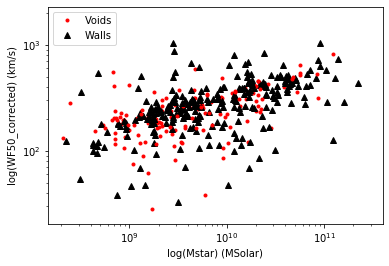

In [230]:
#Plot log(corrected WF50) vs log(MStar) while having the voids and walls separated

plt.loglog(alfaHI['Voids'], alfaHI['WF50_corrected'], '.', label = 'Voids', color = 'red')
plt.loglog(alfaHI['Walls'], alfaHI['WF50_corrected'], '^', label = 'Walls', color = 'black')
plt.loglog(mangaHI['Voids'], mangaHI['WF50_corrected'], '.', color = 'red')
plt.loglog(mangaHI['Walls'], mangaHI['WF50_corrected'], '^', color = 'black')
plt.ylabel('log(WF50_corrected) (km/s)')
plt.xlabel('log(Mstar) (MSolar)')
plt.legend()
plt.savefig('plots/log_WF50_corrected-log_Mstar_VoidsAndWalls.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.show()

#### FINDING BEST-FIT LINES 

In [ ]:
#function that is going to be used for all the curve_fit optimization that will be done for the best-fit lines

def f(x, m, b):
    return m*x + b

##### GBT

In [ ]:
#Since we are using log data, we only want positive values
#When both wf50 and void mass are positive, add them to the two void lists
#when both wf50 and wall mass are positive, add them to the two wall lists

manga_wf50_voids_pos = []
manga_wf50_walls_pos = []
manga_voids_pos = []
manga_walls_pos = []

for i in range(len(mangaHI)):
    if mangaHI['Voids'][i] > 0 and mangaHI['WF50_corrected'][i] > 0:
        manga_wf50_voids_pos.append(mangaHI['WF50_corrected'][i])
        manga_voids_pos.append(mangaHI['Voids'][i])
    elif mangaHI['Walls'][i] > 0 and mangaHI['WF50_corrected'][i] > 0:
        manga_wf50_walls_pos.append(mangaHI['WF50_corrected'][i])
        manga_walls_pos.append(mangaHI['Walls'][i])

###### GBT_Voids

In [ ]:
x_data_manga_voids = np.log10(manga_voids_pos)
y_data_manga_voids = np.log10(manga_wf50_voids_pos)

In [ ]:
popt_manga_voids, pcov_manga_voids = curve_fit(f, x_data_manga_voids, y_data_manga_voids)
m_bf_manga_voids, b_bf_manga_voids = popt_manga_voids
m_err_manga_voids, b_err_manga_voids = np.sqrt(np.diag(pcov_manga_voids))
print('m_bf = ' + str(m_bf_manga_voids) + ', b_bf = ' + str(b_bf_manga_voids))
print('m_err = ' + str(m_err_manga_voids) + ', b_err = ' + str(b_err_manga_voids))

###### GBT_Walls

In [ ]:
x_data_manga_walls = np.log10(manga_walls_pos)
y_data_manga_walls = np.log10(manga_wf50_walls_pos)

In [ ]:
popt_manga_walls, pcov_manga_walls = curve_fit(f, x_data_manga_walls, y_data_manga_walls)
m_bf_manga_walls, b_bf_manga_walls = popt_manga_walls
m_err_manga_walls, b_err_manga_walls = np.sqrt(np.diag(pcov_manga_walls))
print('m_bf = ' + str(m_bf_manga_walls) + ', b_bf = ' + str(b_bf_manga_walls))
print('m_err = ' + str(m_err_manga_walls) + ', b_err = ' + str(b_err_manga_walls))

In [ ]:
#Line equations for the best-fit lines

y_data_manga_walls_line = m_bf_manga_walls* x_data_manga_walls + b_bf_manga_walls
y_data_manga_voids_line = m_bf_manga_voids* x_data_manga_voids + b_bf_manga_voids

In [ ]:
#Plot the log(corrected WF50) vs log(MStar) GBT data and also the best fit lines keeping voids and walls separated

plt.plot(x_data_manga_walls, y_data_manga_walls_line , '-', color = 'black', label = 'Walls')
plt.plot(x_data_manga_voids, y_data_manga_voids_line , '-', color = 'red', label = 'Voids')
plt.plot(x_data_manga_voids, y_data_manga_voids , '.', color = 'red', label = 'Voids', alpha = 0.2)
plt.plot(x_data_manga_walls, y_data_manga_walls, '^', color = 'black', label = 'Walls', alpha = 0.2)
plt.ylabel('log(WF50_corrected) (km/s)')
plt.xlabel('log(Mstar) (MSolar)')
plt.title('GBT')
plt.legend()
#plt.savefig('plots/log_WF50_corrected-log_Mstar_VoidsAndWalls.svg', dpi=500, facecolor='w', edgecolor='w',
     #   orientation='portrait', format='svg', pad_inches=0.1)
plt.show()

##### ALFALFA



In [ ]:
#Since we are using log data, we only want positive values
#When both wf50 and void mass are positive, add them to the two void lists
#when both wf50 and wall mass are positive, add them to the two wall lists

alfa_wf50_voids_pos = []
alfa_wf50_walls_pos = []
alfa_voids_pos = []
alfa_walls_pos = []

for i in range(len(alfaHI)):
    if alfaHI['Voids'][i] > 0 and alfaHI['WF50_corrected'][i] > 0:
        alfa_wf50_voids_pos.append(alfaHI['WF50_corrected'][i])
        alfa_voids_pos.append(alfaHI['Voids'][i])
    elif alfaHI['Walls'][i] > 0 and alfaHI['WF50_corrected'][i] > 0:
        alfa_wf50_walls_pos.append(alfaHI['WF50_corrected'][i])
        alfa_walls_pos.append(alfaHI['Walls'][i])

###### ALFALFA_Voids

In [ ]:
x_data_alfa_voids = np.log10(alfa_voids_pos)
y_data_alfa_voids = np.log10(alfa_wf50_voids_pos)

popt_alfa_voids, pcov_alfa_voids = curve_fit(f, x_data_alfa_voids, y_data_alfa_voids)
m_bf_alfa_voids, b_bf_alfa_voids = popt_alfa_voids
m_err_alfa_voids, b_err_alfa_voids = np.sqrt(np.diag(pcov_alfa_voids))
print('m_bf = ' + str(m_bf_alfa_voids) + ', b_bf = ' + str(b_bf_alfa_voids))
print('m_err = ' + str(m_err_alfa_voids) + ', b_err = ' + str(b_err_alfa_voids))


###### ALFALFA_Walls

In [ ]:
x_data_alfa_walls = np.log10(alfa_walls_pos)
y_data_alfa_walls = np.log10(alfa_wf50_walls_pos)

popt_alfa_walls, pcov_alfa_walls = curve_fit(f, x_data_alfa_walls, y_data_alfa_walls)
m_bf_alfa_walls, b_bf_alfa_walls = popt_alfa_walls
m_err_alfa_walls, b_err_alfa_walls = np.sqrt(np.diag(pcov_alfa_walls))
print('m_bf = ' + str(m_bf_alfa_walls) + ', b_bf = ' + str(b_bf_alfa_walls))
print('m_err = ' + str(m_err_alfa_walls) + ', b_err = ' + str(b_err_alfa_walls))

In [ ]:
#Line equations for the best-fit lines

y_data_alfa_walls_line = m_bf_alfa_walls* x_data_alfa_walls + b_bf_alfa_walls
y_data_alfa_voids_line = m_bf_alfa_voids* x_data_alfa_voids + b_bf_alfa_voids

In [ ]:
#Plot the log(corrected WF50) vs log(MStar) ALFALFA data and also the best fit lines keeping voids and walls separated

plt.plot(x_data_alfa_voids, y_data_alfa_voids , '.', label = 'Voids', color = 'red', alpha = 0.2)
plt.plot(x_data_alfa_walls, y_data_alfa_walls , '^', label = 'Walls', color = 'black', alpha = 0.2)
plt.plot(x_data_alfa_walls,y_data_alfa_walls_line , '-', color = 'black', label = 'Walls')
plt.plot(x_data_alfa_voids, y_data_alfa_voids_line , '-', color = 'red', label = 'Voids')

plt.ylabel('log(WF50_corrected) (km/s)')
plt.xlabel('log(Mstar) (MSolar)')
plt.title('ALFALFA')
plt.legend()
#plt.savefig('plots/log_WF50_corrected-log_Mstar_VoidsAndWalls.svg', dpi=500, facecolor='w', edgecolor='w',
 #       orientation='portrait', format='svg', pad_inches=0.1)
plt.show()

### TO-DO List (6/5/20 and 6/9/20):

>&#10004;Plot putting all the walls together and the voids together\
>&#10004;Plot for just HI-mass\
>&#10004;Plot for sum of HI and MStar



###### ALL

In [ ]:
#Making a list for all galaxies together where voids and walls are not separated

manga_wf50_pos = []
manga_MStar_pos = []
alfa_wf50_pos =  []
alfa_MStar_pos = []


for i in range(len(mangaHI)):
    if mangaHI['WF50_corrected'][i] > 0 and mangaHI['MStar'][i] > 0:
        manga_wf50_pos.append(mangaHI['WF50_corrected'][i])
        manga_MStar_pos.append(mangaHI['MStar'][i])

for i in range(len(alfaHI)):
     if alfaHI['WF50_corrected'][i] > 0 and alfaHI['MStar'][i] > 0:
        alfa_wf50_pos.append(alfaHI['WF50_corrected'][i])
        alfa_MStar_pos.append(alfaHI['MStar'][i])

In [ ]:
#Joins both GBT and ALFALFA wf50 and MStar lists

wf50_pos = manga_wf50_pos + alfa_wf50_pos 
MStar_pos = manga_MStar_pos + alfa_MStar_pos

In [ ]:
y_data_wf50 = np.log10(wf50_pos)
x_data_MStar = np.log10(MStar_pos)

popt_all, pcov_all = curve_fit(f, x_data_MStar, y_data_wf50)
m_bf_all, b_bf_all = popt_all
m_err_all, b_err_all = np.sqrt(np.diag(pcov_all))
m_bf_all_2 = round(m_bf_all, 2)
b_bf_all_2 = round(b_bf_all, 2)
print('m_bf = ' + str(m_bf_all) + ', b_bf = ' + str(b_bf_all))
print('m_err = ' + str(m_err_all) + ', b_err = ' + str(b_err_all))

In [ ]:
#Line equations for the best-fit lines for all galaxies from both GBT and ALFALFA

y_data_wf50_line = m_bf_all* x_data_MStar + b_bf_all
print('Best-fit line equation for all galaxies MStar given by the equation: log(WF50 velocity) = ' + str(m_bf_all_2) + 'log(MStar) + ' +  str(b_bf_all_2))

In [ ]:
#Joins both GBT and ALFALFA wf50 and void/wall lists
wf50_voids_pos = manga_wf50_voids_pos + alfa_wf50_voids_pos 
wf50_walls_pos = manga_wf50_walls_pos + alfa_wf50_walls_pos 
voids_pos = manga_voids_pos + alfa_voids_pos
walls_pos = manga_walls_pos + alfa_walls_pos

In [ ]:
y_data_voids = np.log10(wf50_voids_pos)
x_data_voids = np.log10(voids_pos)

popt_voids, pcov_voids = curve_fit(f, x_data_voids, y_data_voids)
m_bf_voids, b_bf_voids = popt_voids
m_err_voids, b_err_voids = np.sqrt(np.diag(pcov_voids))
m_bf_voids_2 = round(m_bf_voids, 2)
b_bf_voids_2 = round(b_bf_voids, 2)
print('m_bf = ' + str(m_bf_voids) + ', b_bf = ' + str(b_bf_voids))
print('m_err = ' + str(m_err_voids) + ', b_err = ' + str(b_err_voids))


In [ ]:
y_data_voids_line = m_bf_voids* x_data_voids + b_bf_voids
print('Best-fit line equation for void galaxies MStar given by the equation: log(V.WF50 velocity) = ' + str(m_bf_voids_2) + 'log(V.MStar) + ' +  str(b_bf_voids_2))

In [ ]:
y_data_walls = np.log10(wf50_walls_pos)
x_data_walls = np.log10(walls_pos)

popt_walls, pcov_walls = curve_fit(f, x_data_walls, y_data_walls)
m_bf_walls, b_bf_walls = popt_walls
m_err_walls, b_err_walls = np.sqrt(np.diag(pcov_walls))
m_bf_walls_2 = round(m_bf_walls, 2)
b_bf_walls_2 = round(b_bf_walls, 2)
print('m_bf = ' + str(m_bf_walls) + ', b_bf = ' + str(b_bf_walls))
print('m_err = ' + str(m_err_walls) + ', b_err = ' + str(b_err_walls))


In [ ]:
y_data_walls_line = m_bf_walls* x_data_walls + b_bf_walls
print('Best-fit line equation for void galaxies MStar given by the equation: log(V.WF50 velocity) = ' + str(m_bf_walls_2) + 'log(V.MStar) + ' +  str(b_bf_walls_2))


###### PLOTS

In [ ]:
#Plotting the voids, walls from data table and the best-fit lines
#log(W.WF50 velocity) = 0.21log(W.MStar) + 0.31
#log(V.WF50 velocity) = 0.20log(V.MStar) + 0.45
#log(WF50 velocity) = 0.23log(MStar) + 0.13

plt.plot(x_data_MStar, y_data_wf50, 'o', color = 'green', alpha = 0.2, fillstyle = 'none')
plt.plot(x_data_voids, y_data_voids , '.', label = 'Voids', color = 'red', alpha = 0.18)
plt.plot(x_data_walls, y_data_walls , '^', label = 'Walls', color = 'black', alpha = 0.18)
plt.plot(x_data_walls,y_data_walls_line , '-', color = 'black', label = 'Walls')
plt.plot(x_data_voids, y_data_voids_line , '-', color = 'red', label = 'Voids')
plt.plot(x_data_MStar, y_data_wf50_line, '-', color = 'cyan', label = 'All galaxy')
plt.ylabel('log(WF50) (km/s)')
plt.xlabel('log(Mstar) (MSolar)')
plt.legend()
plt.savefig('plots/log_WF50_corrected-log_Mstar_bestFit.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.savefig('plots/log_WF50_corrected-log_Mstar_bestFit.jpeg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='jpeg', pad_inches=0.1)

plt.show()

##### Plotting HI-Mass

##### GBT

In [ ]:
#GBT voids and manga HI mass and WF50 separated

manga_wf50_voids_HI_pos = []
manga_voids_HI_pos = []
manga_wf50_walls_HI_pos = []
manga_walls_HI_pos = []
    
for i in range(len(mangaHI)):
    if mangaHI['WF50_corrected'][i] > 0 and mangaHI['Voids'][i] > 0:
        manga_wf50_voids_HI_pos.append(mangaHI['WF50_corrected'][i])
        manga_voids_HI_pos.append(mangaHI['logMHI_corrected'][i])
       
       
    elif mangaHI['WF50_corrected'][i] > 0 and mangaHI['Walls'][i] > 0:
        manga_wf50_walls_HI_pos.append(mangaHI['WF50_corrected'][i])
        manga_walls_HI_pos.append(mangaHI['logMHI_corrected'][i])

# masking some of the outliers
j=0
while j < len(manga_voids_HI_pos):
     if manga_voids_HI_pos[j] <= 8.6:
            manga_voids_HI_pos.remove(manga_voids_HI_pos[j])
            manga_wf50_voids_HI_pos.remove(manga_wf50_voids_HI_pos[j])
     else:
        j += 1



###### ALFALFA

In [ ]:
alfa_wf50_voids_HI_pos = []
alfa_voids_HI_pos = []
alfa_wf50_walls_HI_pos = []
alfa_walls_HI_pos = []
    
for i in range(len(alfaHI)):
    if alfaHI['WF50_corrected'][i] > 0 and alfaHI['Voids'][i] > 0:
        alfa_wf50_voids_HI_pos.append(alfaHI['WF50_corrected'][i])
        alfa_voids_HI_pos.append(alfaHI['logMHI_corrected'][i])
    elif alfaHI['WF50_corrected'][i] > 0 and alfaHI['Walls'][i] > 0:
        alfa_wf50_walls_HI_pos.append(alfaHI['WF50_corrected'][i])
        alfa_walls_HI_pos.append(alfaHI['logMHI_corrected'][i])
        


###### Concatenation

In [ ]:
#Combines the voids of GBT set and ALFALFA set
wf50_voids_HI_pos = np.log10(alfa_wf50_voids_HI_pos + manga_wf50_voids_HI_pos)
voids_HI_pos = alfa_voids_HI_pos + manga_voids_HI_pos

#Combines the walls of GBT set and ALFALFA set
wf50_walls_HI_pos = np.log10(alfa_wf50_walls_HI_pos + manga_wf50_walls_HI_pos)
walls_HI_pos = alfa_walls_HI_pos + manga_walls_HI_pos

##### VOIDS

In [ ]:
y_data_voids_HI = wf50_voids_HI_pos
x_data_voids_HI = np.array(voids_HI_pos, dtype = np.float64)

popt_voids_HI, pcov_voids_HI = curve_fit(f, x_data_voids_HI, y_data_voids_HI)
m_bf_voids_HI, b_bf_voids_HI = popt_voids_HI
m_err_voids_HI, b_err_voids_HI = np.sqrt(np.diag(pcov_voids_HI))
m_bf_voids_HI_2 = round(m_bf_voids_HI, 2)
b_bf_voids_HI_2 = round(b_bf_voids_HI, 2)
print('m_bf = ' + str(m_bf_voids_HI) + ', b_bf = ' + str(b_bf_voids_HI))
print('m_err = ' + str(m_err_voids_HI) + ', b_err = ' + str(b_err_voids_HI))

In [ ]:
y_data_voids_HI_line = m_bf_voids_HI* x_data_voids_HI + b_bf_voids_HI
print('Best-fit line equation for void galaxies HI-mass given by the equation: log(V.WF50 velocity) = ' + str(m_bf_voids_HI_2) + 'log(V.HI-mass) + ' +  str(b_bf_voids_HI_2))

###### WALLS

In [ ]:
y_data_walls_HI = wf50_walls_HI_pos
x_data_walls_HI = np.array(walls_HI_pos, dtype = np.float64)

popt_walls_HI, pcov_walls_HI = curve_fit(f, x_data_walls_HI, y_data_walls_HI)
m_bf_walls_HI, b_bf_walls_HI = popt_walls_HI
m_err_walls_HI, b_err_walls_HI = np.sqrt(np.diag(pcov_walls_HI))
m_bf_walls_HI_2 = round(m_bf_walls_HI, 2)
b_bf_walls_HI_2 = round(b_bf_walls_HI, 2)
print('m_bf = ' + str(m_bf_walls_HI) + ', b_bf = ' + str(b_bf_walls_HI))
print('m_err = ' + str(m_err_walls_HI) + ', b_err = ' + str(b_err_walls_HI))

In [ ]:
y_data_walls_HI_line = m_bf_walls_HI* x_data_walls_HI + b_bf_walls_HI
print('Best-fit line equation for wall galaxies HI-mass given by the equation: log(W.WF50 velocity) = ' + str(m_bf_walls_HI_2) + 'log(W.HI-mass)' +  str(b_bf_walls_HI_2))

###### ALL

In [ ]:
#Picking out the postive values for wf50 and HI mass from GBT and ALFALFA data

manga_wf50_HI_pos = []
manga_HI_pos = []
alfa_wf50_HI_pos = []
alfa_HI_pos = []

for i in range(len(mangaHI)):
    if mangaHI['WF50_corrected'][i] > 0 and mangaHI['logMHI_corrected'][i] > 0:
        manga_wf50_HI_pos.append(mangaHI['WF50_corrected'][i])
        manga_HI_pos.append(mangaHI['logMHI'][i])

for i in range(len(alfaHI)):
     if alfaHI['WF50_corrected'][i] > 0 and alfaHI['logMHI_corrected'][i] > 0:
        alfa_wf50_HI_pos.append(alfaHI['WF50_corrected'][i])
        alfa_HI_pos.append(alfaHI['logMHI_corrected'][i])

In [ ]:
#Joining ALFALFA and GBT data

all_wf50_HI_pos = manga_wf50_HI_pos + alfa_wf50_HI_pos
all_HI_pos = manga_HI_pos + alfa_HI_pos

In [ ]:
y_data_all_HI = np.log10(all_wf50_HI_pos)
x_data_all_HI = np.array(all_HI_pos,dtype=np.float64)

popt_all_HI, pcov_all_HI = curve_fit(f, x_data_all_HI, y_data_all_HI)
m_bf_all_HI, b_bf_all_HI = popt_all_HI
m_err_all_HI, b_err_all_HI = np.sqrt(np.diag(pcov_all_HI))
m_bf_all_HI_2 = round(m_bf_all_HI, 2)
b_bf_all_HI_2 = round(b_bf_all_HI, 2)
print('m_bf = ' + str(m_bf_all_HI) + ', b_bf = ' + str(b_bf_all_HI))
print('m_err = ' + str(m_err_all_HI) + ', b_err = ' + str(b_err_all_HI))

In [ ]:
y_data_all_HI_line = m_bf_all_HI* x_data_all_HI + b_bf_all_HI

print('Best-fit line equation for HI-mass given by the equation: log(WF50 velocity) = ' + str(m_bf_all_HI_2) + 'log(HI-Mass)' +  str(b_bf_all_HI_2))

###### PLOTS

In [ ]:
#Plotting HI-data and wf50 from data table and the best-fit lines
#log(V.WF50 velocity) = 0.27log(V.HI-mass) - 0.25
#log(W.WF50 velocity) = 0.35log(W.HI-mass)-1.03
#log(WF50 velocity) = 0.33log(HI-Mass)-0.84
plt.plot(x_data_all_HI, y_data_all_HI, 'o', color = 'green', alpha = 0.2, fillstyle = 'none')
plt.plot(x_data_walls_HI, y_data_walls_HI, '^', color = 'black', alpha = 0.2, label = 'Walls')
plt.plot(x_data_voids_HI, y_data_voids_HI, '.', color = 'red', alpha = 0.2, label = 'Voids')
plt.plot(x_data_voids_HI, y_data_voids_HI_line, '-', color = 'red', label = 'Voids')
plt.plot(x_data_walls_HI, y_data_walls_HI_line, '-', color = 'black', label = 'Walls')
plt.plot(x_data_all_HI, y_data_all_HI_line, '-', label = 'best-fit', color = 'cyan')
plt.xlim(xmin = 8)
plt.xlabel('log(MHI) (MSun)')
plt.ylabel('log(WF50) (km/s)')
plt.legend()
plt.savefig('plots/log_WF50_corrected-log_HI_bestFit.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.savefig('plots/log_WF50_corrected-log_HI_bestFit.jpeg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='jpeg', pad_inches=0.1)
plt.show()

##### Plot for sum of HI mass and MStar

##### GBT

In [ ]:
#Adding a column of the sum of HI and MStar to GBT
manga_totMass = []
for i in range(len(mangaHI)):
    if mangaHI['MHI'][i]> 0:
        manga_totMass.append(mangaHI['MHI_corrected'][i] + mangaHI['MStar'][i])
    else:
        manga_totMass.append(-999.0)

#mangaHI.remove_column('MTotal')
mangaHI.add_column(Column(np.asarray(manga_totMass, dtype = np.float64, order = 'F'), name = 'MTotal'), index=15)

In [ ]:
#Picking out the positive values

manga_wf50_Tot_voids_pos = []
manga_MTot_voids_pos = []
manga_wf50_Tot_walls_pos = []
manga_MTot_walls_pos = []

for i in range(len(mangaHI)):
    if mangaHI['WF50_corrected'][i] > 0 and mangaHI['Voids'][i] > 0 and mangaHI['MHI'][i] != 0.0:
        manga_wf50_Tot_voids_pos.append(mangaHI['WF50_corrected'][i])
        manga_MTot_voids_pos.append(mangaHI['MTotal'][i])
    elif mangaHI['WF50_corrected'][i] > 0 and mangaHI['Walls'][i] > 0 and mangaHI['MHI'][i] != 0.0:
        manga_wf50_Tot_walls_pos.append(mangaHI['WF50_corrected'][i])
        manga_MTot_walls_pos.append(mangaHI['MTotal'][i])



##### ALFALFA

In [ ]:
#Adding a column of the sum of HI and MStar to ALFALFA 
alfa_totMass = []
for i in range(len(alfaHI)):
    if alfaHI['MHI'][i]> 0:
        alfa_totMass.append(alfaHI['MHI_corrected'][i] + alfaHI['MStar'][i])
    else:
        alfa_totMass.append(-999.0)

#alfaHI.remove_column('MTotal')
alfaHI.add_column(Column(np.asarray(alfa_totMass, dtype = np.float64, order = 'F'), name = 'MTotal'), index=12)

In [ ]:
#Picking out the positive values

alfa_wf50_Tot_voids_pos = []
alfa_MTot_voids_pos = []
alfa_wf50_Tot_walls_pos = []
alfa_MTot_walls_pos = []

for i in range(len(alfaHI)):
    if alfaHI['WF50_corrected'][i] > 0 and alfaHI['Voids'][i] > 0 and alfaHI['MHI'][i] != 0.0:
        alfa_wf50_Tot_voids_pos.append(alfaHI['WF50_corrected'][i])
        alfa_MTot_voids_pos.append(alfaHI['MTotal'][i])
    elif alfaHI['WF50_corrected'][i] > 0 and alfaHI['Walls'][i] > 0 and alfaHI['MHI'][i] != 0.0:
        alfa_wf50_Tot_walls_pos.append(alfaHI['WF50_corrected'][i])
        alfa_MTot_walls_pos.append(alfaHI['MTotal'][i])


##### Concatenation

In [ ]:
#Joining ALFALFA and GBT data

wf50_Tot_voids_pos = alfa_wf50_Tot_voids_pos + manga_wf50_Tot_voids_pos
MTot_voids_pos = alfa_MTot_voids_pos + manga_MTot_voids_pos
wf50_Tot_walls_pos = alfa_wf50_Tot_walls_pos + manga_wf50_Tot_walls_pos
MTot_walls_pos = alfa_MTot_walls_pos + manga_MTot_walls_pos

###### VOIDS

In [ ]:
y_data_Tot_voids = np.log10(wf50_Tot_voids_pos)
x_data_Tot_voids = np.log10(MTot_voids_pos)

popt_Tot_voids, pcov_Tot_voids = curve_fit(f, x_data_Tot_voids, y_data_Tot_voids)
m_bf_Tot_voids, b_bf_Tot_voids = popt_Tot_voids
m_err_Tot_voids, b_err_Tot_voids = np.sqrt(np.diag(pcov_Tot_voids))
m_bf_Tot_voids_2 = round(m_bf_Tot_voids, 2)
b_bf_Tot_voids_2 = round(b_bf_Tot_voids, 2)
print('m_bf = ' + str(m_bf_Tot_voids) + ', b_bf = ' + str(b_bf_Tot_voids))
print('m_err = ' + str(m_err_Tot_voids) + ', b_err = ' + str(b_err_Tot_voids))

In [ ]:
y_data_Tot_voids_line = m_bf_Tot_voids * x_data_Tot_voids + b_bf_Tot_voids
print('Best-fit line equation for void galaxy (HI+Stellar)-mass given by the equation: log(V.WF50 velocity) = ' + str(m_bf_Tot_voids_2) + 'log(V.(HI+Stellar)-Mass)' +  str(b_bf_Tot_voids_2))

##### WALLS

In [ ]:
y_data_Tot_walls = np.log10(wf50_Tot_walls_pos)
x_data_Tot_walls = np.log10(MTot_walls_pos)

popt_Tot_walls, pcov_Tot_walls = curve_fit(f, x_data_Tot_walls, y_data_Tot_walls)
m_bf_Tot_walls, b_bf_Tot_walls = popt_Tot_walls
m_err_Tot_walls, b_err_Tot_walls = np.sqrt(np.diag(pcov_Tot_walls))
m_bf_Tot_walls_2 = round(m_bf_Tot_walls, 2)
b_bf_Tot_walls_2 = round(b_bf_Tot_walls, 2)
print('m_bf = ' + str(m_bf_Tot_walls) + ', b_bf = ' + str(b_bf_Tot_walls))
print('m_err = ' + str(m_err_Tot_walls) + ', b_err = ' + str(b_err_Tot_walls))

In [ ]:
y_data_Tot_walls_line = m_bf_Tot_walls * x_data_Tot_walls + b_bf_Tot_walls
print('Best-fit line equation for wall galaxy (HI+Stellar)-mass given by the equation: log(W.WF50 velocity) = ' + str(m_bf_Tot_walls_2) + 'log(W.(HI+Stellar)-Mass)' +  str(b_bf_Tot_walls_2))

##### ALL

In [ ]:
#Putting all galaxies together

wf50_Tot_all = wf50_Tot_voids_pos+wf50_Tot_walls_pos
MTot_all = MTot_voids_pos + MTot_walls_pos

In [ ]:
y_data_Tot_all = np.log10(wf50_Tot_all)
x_data_Tot_all = np.log10(MTot_all)

popt_Tot_all, pcov_Tot_all = curve_fit(f, x_data_Tot_all, y_data_Tot_all)
m_bf_Tot_all, b_bf_Tot_all = popt_Tot_all
m_err_Tot_all, b_err_Tot_all = np.sqrt(np.diag(pcov_Tot_all))
m_bf_Tot_all_2 = round(m_bf_Tot_all, 2)
b_bf_Tot_all_2 = round(b_bf_Tot_all, 2)
print('m_bf = ' + str(m_bf_Tot_all) + ', b_bf = ' + str(b_bf_Tot_all))
print('m_err = ' + str(m_err_Tot_all) + ', b_err = ' + str(b_err_Tot_all))

In [ ]:
y_data_Tot_all_line = m_bf_Tot_all * x_data_Tot_all + b_bf_Tot_all
print('Best-fit line equation for all galaxy (HI+Stellar)-mass given by the equation: log(WF50 velocity) = ' + str(m_bf_Tot_all_2) + 'log((HI+Stellar)-Mass)' +  str(b_bf_Tot_all_2))

##### PLOTS

In [ ]:
#Plotting HI+Stellar and wf50 from data table and the best-fit lines
#log(W.WF50 velocity) = 0.31log(W.(HI+Stellar)-Mass)-0.73
#log(V.WF50 velocity) = 0.29log(V.(HI+Stellar)-Mass)-0.56
#log(WF50 velocity) = 0.31log((HI+Stellar)-Mass)-0.7

plt.plot(x_data_Tot_all, y_data_Tot_all, 'o', color = 'green', alpha = 0.18, fillstyle = 'none')
plt.plot(x_data_Tot_voids, y_data_Tot_voids , '.', label = 'Voids', color = 'red', alpha = 0.18)
plt.plot(x_data_Tot_walls, y_data_Tot_walls , '^', label = 'Walls', color = 'black', alpha = 0.18)
plt.plot(x_data_Tot_walls,y_data_Tot_walls_line , '-', color = 'black', label = 'Walls')
plt.plot(x_data_Tot_voids, y_data_Tot_voids_line , '-', color = 'red', label = 'Voids')
plt.plot(x_data_Tot_all, y_data_Tot_all_line, '-', color = 'cyan', label = 'All galaxy')
plt.ylabel('log(WF50) (km/s)')
plt.xlabel('log(M*+MHI) (MSolar)')
plt.legend()
plt.savefig('plots/log_WF50_corrected-log_MStar+HI_bestFit.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.savefig('plots/log_WF50_corrected-log_MStar+HI_bestFit.jpeg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='jpeg', pad_inches=0.1)

plt.show()

###### MStar vs HI-mass

>Let’s look at the relationship between the MStar and the HI mass.  Plot log(M*) v. log(M_HI), coloring voids red and walls black, and fit linear relationships for the voids, the walls, and all the galaxies together.

##### GBT

In [ ]:
manga_MStar_voids = []
manga_MStar_walls = []
manga_HI_voids = []
manga_HI_walls = []

for i in range(len(mangaHI)):
    if mangaHI['Voids'][i] > 0 and mangaHI['logMHI_corrected'][i] > 0:
        manga_MStar_voids.append(mangaHI['MStar'][i])
        manga_HI_voids.append(mangaHI['logMHI_corrected'][i])
    elif mangaHI['Walls'][i] > 0 and mangaHI['logMHI_corrected'][i] > 0:
        manga_MStar_walls.append(mangaHI['MStar'][i])
        manga_HI_walls.append(mangaHI['logMHI_corrected'][i])
        
# masking some of the outliers
j=0
while j < len(manga_HI_voids):
     if manga_HI_voids[j] <= 8:
            manga_HI_voids.remove(manga_HI_voids[j])
            manga_MStar_voids.remove( manga_MStar_voids[j])
     else:
        j += 1

k=0
while k < len(manga_HI_walls):
     if manga_HI_walls[k] <= 8:
            manga_HI_walls.remove(manga_HI_walls[k])
            manga_MStar_walls.remove( manga_MStar_walls[k])
     else:
        k += 1

##### ALFALFA

In [ ]:
alfa_MStar_voids = []
alfa_MStar_walls = []
alfa_HI_voids = []
alfa_HI_walls = []

for i in range(len(alfaHI)):
    if alfaHI['Voids'][i] > 0 and alfaHI['logMHI_corrected'][i] > 0:
        alfa_MStar_voids.append(alfaHI['MStar'][i])
        alfa_HI_voids.append(alfaHI['logMHI_corrected'][i])
    elif alfaHI['Walls'][i] > 0 and alfaHI['logMHI_corrected'][i] > 0:
        alfa_MStar_walls.append(alfaHI['MStar'][i])
        alfa_HI_walls.append(alfaHI['logMHI_corrected'][i])  
        
# masking some of the outliers
l=0
while l < len(alfa_HI_voids):
     if alfa_HI_voids[j] <= 8:
            alfa_HI_voids.remove(alfa_HI_voids[j])
            alfa_MStar_voids.remove(alfa_MStar_voids[j])
     else:
        l += 1

m=0
while m < len(alfa_HI_walls):
     if alfa_HI_walls[k] <= 8:
            alfa_HI_walls.remove(alfa_HI_walls[k])
            alfa_MStar_walls.remove(alfa_MStar_walls[k])
     else:
        m += 1

##### Concatenation

In [ ]:
MStar_voids = alfa_MStar_voids + manga_MStar_voids
HI_voids =  alfa_HI_voids + manga_HI_voids

MStar_walls = alfa_MStar_walls + manga_MStar_walls
HI_walls =  alfa_HI_walls + manga_HI_walls

##### VOIDS

In [ ]:
y_data_voids_mass = np.log10(MStar_voids)
x_data_voids_mass = np.array(HI_voids, dtype = np.float64)

popt_voids_mass, pcov_voids_mass = curve_fit(f, x_data_voids_mass, y_data_voids_mass)
m_bf_voids_mass, b_bf_voids_mass = popt_voids_mass
m_err_voids_mass, b_err_voids_mass = np.sqrt(np.diag(pcov_voids_mass))
m_bf_voids_mass_2 = round(m_bf_voids_mass, 2)
b_bf_voids_mass_2 = round(b_bf_voids_mass, 2)
print('m_bf = ' + str(m_bf_voids_mass) + ', b_bf = ' + str(b_bf_voids_mass))
print('m_err = ' + str(m_err_voids_mass) + ', b_err = ' + str(b_err_voids_mass))

In [ ]:
y_data_voids_mass_line = m_bf_voids_mass * x_data_voids_mass + b_bf_voids_mass
print('Best-fit line equation for void galaxy M* vs HI given by the equation: log(V.M*)) = ' + str(m_bf_voids_mass_2) + 'log(V.HI) + ' +  str(b_bf_voids_mass_2))

##### WALLS

In [ ]:
y_data_walls_mass = np.log10(MStar_walls)
x_data_walls_mass = np.array(HI_walls, dtype = np.float64)

popt_walls_mass, pcov_walls_mass = curve_fit(f, x_data_walls_mass, y_data_walls_mass)
m_bf_walls_mass, b_bf_walls_mass = popt_walls_mass
m_err_walls_mass, b_err_walls_mass = np.sqrt(np.diag(pcov_walls_mass))
m_bf_walls_mass_2 = round(m_bf_walls_mass, 2)
b_bf_walls_mass_2 = round(b_bf_walls_mass, 2)
print('m_bf = ' + str(m_bf_walls_mass) + ', b_bf = ' + str(b_bf_walls_mass))
print('m_err = ' + str(m_err_walls_mass) + ', b_err = ' + str(b_err_walls_mass))

In [ ]:
y_data_walls_mass_line = m_bf_walls_mass * x_data_walls_mass + b_bf_walls_mass
print('Best-fit line equation for wall galaxy M* vs HI given by the equation: log(W.M*)) = ' + str(m_bf_walls_mass_2) + 'log(W.HI) + ' +  str(b_bf_walls_mass_2))

##### ALL

In [ ]:
MStar_all = MStar_voids+MStar_walls
HI_all = HI_voids+HI_walls

In [ ]:
y_data_mass_all = np.log10(MStar_all)
x_data_mass_all = np.array(HI_all, dtype = np.float64)

popt_mass_all, pcov_mass_all = curve_fit(f, x_data_mass_all, y_data_mass_all)
m_bf_mass_all, b_bf_mass_all = popt_mass_all
m_err_mass_all, b_err_mass_all = np.sqrt(np.diag(pcov_mass_all))
m_bf_mass_all_2 = round(m_bf_mass_all, 2)
b_bf_mass_all_2 = round(b_bf_mass_all, 2)
print('m_bf = ' + str(m_bf_mass_all) + ', b_bf = ' + str(b_bf_mass_all))
print('m_err = ' + str(m_err_mass_all) + ', b_err = ' + str(b_err_mass_all))

In [ ]:
y_data_mass_all_line = m_bf_mass_all * x_data_mass_all + b_bf_mass_all
print('Best-fit line equation for all galaxy M* vs HI given by the equation: log(M*)) = ' + str(m_bf_mass_all_2) + 'log(HI) + ' +  str(b_bf_mass_all_2))

##### PLOTS

In [ ]:
#MStar vs HI mass plots for voids, walls, and all galaxy
#log(V.M*)) = 0.64log(V.HI) + 3.52
#log(W.M*)) = 0.93log(W.HI) + 0.81
#log(M*)) = 0.82log(HI) + 1.83

plt.plot(x_data_mass_all, y_data_mass_all, 'o', color = 'green', alpha = 0.18, fillstyle = 'none')
plt.plot(x_data_voids_mass, y_data_voids_mass , '.', label = 'Voids', color = 'red', alpha = 0.18)
plt.plot(x_data_walls_mass, y_data_walls_mass , '^', label = 'Walls', color = 'black', alpha = 0.18)
plt.plot(x_data_walls_mass,y_data_walls_mass_line , '-', color = 'black', label = 'Walls')
plt.plot(x_data_voids_mass, y_data_voids_mass_line , '-', color = 'red', label = 'Voids')
plt.plot(x_data_mass_all, y_data_mass_all_line, '-', color = 'cyan', label = 'All galaxy')
plt.xlabel('log(MHI) (MSolar)')
plt.ylabel('log(MStar) (MSolar)')
plt.legend()
plt.show()

### WF50_corrected vs v_max plot

##### ADDING VMAX COLUMN TO GBT AND ALFALFA DATA

In [ ]:
#curve_used = 0, 1, -1 avg_vmax, pos, neg 
manga_avg_vmax = []
manga_pos_vmax = []
manga_neg_vmax = []

for i in range(len(mangaHI)):
    for j in range(len(table2)):
        if (mangaHI['Plate'][i], mangaHI['IFU'][i]) == (table2['MaNGA_plate'][j], table2['MaNGA_IFU'][j]):
            if table2['curve_used'][j] == 0:
                manga_avg_vmax.append(table2['avg_v_max'][j])
                manga_pos_vmax.append(-999.0)
                manga_neg_vmax.append(-999.0)
            elif table2['curve_used'][j] == 1:
                manga_avg_vmax.append(-999.0)
                manga_pos_vmax.append(table2['pos_v_max'][j])
                manga_neg_vmax.append(-999.0)
            elif table2['curve_used'][j] == -1:
                manga_avg_vmax.append(-999.0)
                manga_pos_vmax.append(-999.0)
                manga_neg_vmax.append(table2['neg_v_max'][j])
            else:
                manga_avg_vmax.append(-99.0)
                manga_pos_vmax.append(-99.0)
                manga_neg_vmax.append(-99.0)
    
mangaHI.add_column(Column(np.asarray(manga_avg_vmax, dtype=np.float64, order='F'), name='avg_v_max'))
mangaHI.add_column(Column(np.asarray(manga_pos_vmax, dtype=np.float64, order='F'), name='pos_v_max'))
mangaHI.add_column(Column(np.asarray(manga_neg_vmax, dtype=np.float64, order='F'), name='neg_v_max'))

In [ ]:
mangaHI.write('out_txt/MaNGAHI_with_vmax.txt', format = 'ascii.commented_header', overwrite = True)

In [ ]:
alfa_avg_vmax = []
alfa_pos_vmax = []
alfa_neg_vmax = []

for i in range(len(alfaHI)):
    for j in range(len(table2)):
        if (alfaHI['Plate'][i], alfaHI['IFU'][i]) == (table2['MaNGA_plate'][j], table2['MaNGA_IFU'][j]):
            if table2['curve_used'][j] == 0:
                alfa_avg_vmax.append(table2['avg_v_max'][j])
                alfa_pos_vmax.append(-999.0)
                alfa_neg_vmax.append(-999.0)
            elif table2['curve_used'][j] == 1:
                alfa_avg_vmax.append(-999.0)
                alfa_pos_vmax.append(table2['pos_v_max'][j])
                alfa_neg_vmax.append(-999.0)
            elif table2['curve_used'][j] == -1:
                alfa_avg_vmax.append(-999.0)
                alfa_pos_vmax.append(-999.0)
                alfa_neg_vmax.append(table2['neg_v_max'][j])
            else:
                alfa_avg_vmax.append(-99.0)
                alfa_pos_vmax.append(-99.0)
                alfa_neg_vmax.append(-99.0)
    
alfaHI.add_column(Column(np.asarray(alfa_avg_vmax, dtype=np.float64, order='F'), name='avg_v_max'))
alfaHI.add_column(Column(np.asarray(alfa_pos_vmax, dtype=np.float64, order='F'), name='pos_v_max'))
alfaHI.add_column(Column(np.asarray(alfa_neg_vmax, dtype=np.float64, order='F'), name='neg_v_max'))

In [ ]:
alfaHI.write('out_txt/ALFALFAHI_with_vmax.txt', format = 'ascii.commented_header', overwrite = True)

##### GBT

In [ ]:
manga_wf50_voids_v = []
manga_vmax_voids_v = []
manga_wf50_walls_v = []
manga_vmax_walls_v = []

for i in range(len(mangaHI)):
    if mangaHI['WF50_corrected'][i] > 0 and mangaHI['Voids'][i] > 0:
        if mangaHI['avg_v_max'][i] > 0:
            manga_vmax_voids_v.append(mangaHI['avg_v_max'][i])
            manga_wf50_voids_v.append(mangaHI['WF50_corrected'][i])
        elif mangaHI['pos_v_max'][i] > 0:
            manga_vmax_voids_v.append(mangaHI['pos_v_max'][i])
            manga_wf50_voids_v.append(mangaHI['WF50_corrected'][i])
        elif mangaHI['neg_v_max'][i] > 0:
            manga_vmax_voids_v.append(mangaHI['neg_v_max'][i])
            manga_wf50_voids_v.append(mangaHI['WF50_corrected'][i])
    
    elif mangaHI['WF50_corrected'][i] > 0 and mangaHI['Walls'][i] > 0:
        if mangaHI['avg_v_max'][i] > 0:
            manga_vmax_walls_v.append(mangaHI['avg_v_max'][i])
            manga_wf50_walls_v.append(mangaHI['WF50_corrected'][i])
        elif mangaHI['pos_v_max'][i] > 0:
            manga_vmax_walls_v.append(mangaHI['pos_v_max'][i])
            manga_wf50_walls_v.append(mangaHI['WF50_corrected'][i])
        elif mangaHI['neg_v_max'][i] > 0:
            manga_vmax_walls_v.append(mangaHI['neg_v_max'][i])
            manga_wf50_walls_v.append(mangaHI['WF50_corrected'][i])

##### ALFALFA

In [ ]:
alfa_wf50_voids_v = []
alfa_vmax_voids_v = []
alfa_wf50_walls_v = []
alfa_vmax_walls_v = []

for i in range(len(alfaHI)):
    if alfaHI['WF50_corrected'][i] > 0 and alfaHI['Voids'][i] > 0:
        if alfaHI['avg_v_max'][i] > 0:
            alfa_vmax_voids_v.append(alfaHI['avg_v_max'][i])
            alfa_wf50_voids_v.append(alfaHI['WF50_corrected'][i])
        elif alfaHI['pos_v_max'][i] > 0:
            alfa_vmax_voids_v.append(alfaHI['pos_v_max'][i])
            alfa_wf50_voids_v.append(alfaHI['WF50_corrected'][i])
        elif alfaHI['neg_v_max'][i] > 0:
            alfa_vmax_voids_v.append(alfaHI['neg_v_max'][i])
            alfa_wf50_voids_v.append(alfaHI['WF50_corrected'][i])
    
    elif alfaHI['WF50_corrected'][i] > 0 and alfaHI['Walls'][i] > 0:
        if alfaHI['avg_v_max'][i] > 0:
            alfa_vmax_walls_v.append(alfaHI['avg_v_max'][i])
            alfa_wf50_walls_v.append(alfaHI['WF50_corrected'][i])
        elif alfaHI['pos_v_max'][i] > 0:
            alfa_vmax_walls_v.append(alfaHI['pos_v_max'][i])
            alfa_wf50_walls_v.append(alfaHI['WF50_corrected'][i])
        elif alfaHI['neg_v_max'][i] > 0:
            alfa_vmax_walls_v.append(alfaHI['neg_v_max'][i])
            alfa_wf50_walls_v.append(alfaHI['WF50_corrected'][i])

##### Concatenation

In [ ]:
wf50_voids_v = np.log10(alfa_wf50_voids_v + manga_wf50_voids_v)
vmax_voids_v = np.log10(alfa_vmax_voids_v + manga_vmax_voids_v)

wf50_walls_v = np.log10(alfa_wf50_walls_v + manga_wf50_walls_v)
vmax_walls_v = np.log10(alfa_vmax_walls_v + manga_vmax_walls_v)

##### Plot of best fit line with m=1 to find y-intercept

In [ ]:
wf50_voids_fixed = []
vmax_voids_fixed = []

wf50_walls_fixed = []
vmax_walls_fixed = []

for i in range(len(wf50_voids_v)):
    if wf50_voids_v[i] > vmax_voids_v[i]:
        wf50_voids_fixed.append(wf50_voids_v[i])
        vmax_voids_fixed.append(vmax_voids_v[i])
for j in range(len(wf50_walls_v)):
    if wf50_walls_v[i] > vmax_walls_v[i]:
        wf50_walls_fixed.append(wf50_walls_v[i])
        vmax_walls_fixed.append(vmax_walls_v[i])


In [ ]:
wf50_fixed = wf50_voids_fixed + wf50_walls_fixed
vmax_fixed = vmax_voids_fixed + vmax_walls_fixed

In [ ]:
def g(x, b):
    return x + b

In [ ]:
y_data_vel = wf50_fixed
x_data_vel = vmax_fixed

popt_vel, pcov_vel = curve_fit(g, x_data_vel, y_data_vel)
b_bf_vel = popt_vel
b_err_vel = np.sqrt(np.diag(pcov_vel))
b_bf_vel_2 = np.round(b_bf_vel, 2)
print('m_bf = 1, b_bf = ' + str(b_bf_vel))
print('m_err = 1, b_err = ' + str(b_err_vel))

In [ ]:
y_data_vel_line = x_data_vel + b_bf_vel
print('Best-fit line for wf50 vs vmax for all galaxies given by: log(WF50) = log(vmax) + ' + str(b_bf_vel_2))

##### PLOT

In [ ]:
plt.plot(vmax_voids_v, wf50_voids_v, '.', color = 'red', label = 'voids', alpha = 0.2)
plt.plot(vmax_walls_v, wf50_walls_v, '^', color = 'black', label = 'walls', alpha = 0.2)
plt.plot(x_data_vel, y_data_vel_line, '-', color = 'cyan', label = 'y=x+0.28')
plt.plot([0,3.5], [0,3.5])
plt.xlabel('log(vmax) (km/s)')
plt.ylabel('log(wf50) (km/s)')
plt.ylim(ymin = 0)
plt.legend()
plt.show()

### Binning and median
 >Bin the masses in half-MSolar (and 1 solar MSolar), find the median WF50 for each bin, plot the bin center vs median WF50.\
 >Mass error bars = 0.5 * width of bin & WF50 error bars = 1/sqrt(N), N = number in each bin

#### WF50 vs M*

###### Binning GBT MStares and diving into voids and walls

In [ ]:
#manga_voids_bin1 = []
manga_voids_bin1 = []
manga_voids_bin2 = []
manga_voids_bin3 = []
manga_voids_bin4 = []
manga_voids_bin5 = []
#manga_voids_bin6 = []

for i in range(len(mangaHI)):
    #if 8<=mangaHI['logMStar'][i]<=8.5 and mangaHI['Voids'][i]>0:
        #manga_voids_bin1.append(mangaHI['Voids'][i])
    if 8.5<mangaHI['logMStar'][i]<=9 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_voids_bin1.append(mangaHI['Voids'][i])
    if 9<mangaHI['logMStar'][i]<=9.5 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_voids_bin2.append(mangaHI['Voids'][i])
    if 9.5<mangaHI['logMStar'][i]<=10 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_voids_bin3.append(mangaHI['Voids'][i])
    if 10<mangaHI['logMStar'][i]<=10.5 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_voids_bin4.append(mangaHI['Voids'][i])
    if 10.5<mangaHI['logMStar'][i]<=11 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_voids_bin5.append(mangaHI['Voids'][i])
    #if 11<mangaHI['logMStar'][i]<=11.5 and mangaHI['Voids'][i]>0:
        #manga_voids_bin6.append(mangaHI['Voids'][i])

In [ ]:
#manga_walls_bin1 = []
manga_walls_bin1 = []
manga_walls_bin2 = []
manga_walls_bin3 = []
manga_walls_bin4 = []
manga_walls_bin5 = []
#manga_walls_bin7 = []


for i in range(len(mangaHI)):
    #if 8<=mangaHI['logMStar'][i]<=8.5 and mangaHI['Walls'][i]>0:
        #manga_walls_bin1.append(mangaHI['Walls'][i])
    if 8.5<mangaHI['logMStar'][i]<=9 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_walls_bin1.append(mangaHI['Walls'][i])
    if 9<mangaHI['logMStar'][i]<=9.5 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_walls_bin2.append(mangaHI['Walls'][i])
    if 9.5<mangaHI['logMStar'][i]<=10 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_walls_bin3.append(mangaHI['Walls'][i])
    if 10<mangaHI['logMStar'][i]<=10.5 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_walls_bin4.append(mangaHI['Walls'][i])
    if 10.5<mangaHI['logMStar'][i]<=11 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_walls_bin5.append(mangaHI['Walls'][i])
    #if 11<mangaHI['logMStar'][i]<=11.5 and mangaHI['Walls'][i]>0:
        #manga_walls_bin7.append(mangaHI['Walls'][i])

###### Binning ALFALFA MStares and diving into voids and walls

In [ ]:
#alfa_voids_bin1=[]
#alfa_voids_bin2=[]
#alfa_voids_bin3=[]
alfa_voids_bin1 = []
alfa_voids_bin2 = []
alfa_voids_bin3 = []
alfa_voids_bin4 = []
alfa_voids_bin5 = []
alfa_voids_bin6 = []


for i in range(len(alfaHI)):
    #if 7<=alfaHI['logMStar'][i]<=7.5 and alfaHI['Voids'][i]>0:
    #    alfa_voids_bin1.append(alfaHI['Voids'][i])
    #if 7.5<=alfaHI['logMStar'][i]<=8 and alfaHI['Voids'][i]>0:
    #    alfa_voids_bin2.append(alfaHI['Voids'][i])
    #if 8<alfaHI['logMStar'][i]<=8.5 and alfaHI['Voids'][i]>0:
    #   alfa_voids_bin1.append(alfaHI['Voids'][i])
    if 8.5<alfaHI['logMStar'][i]<=9 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_bin1.append(alfaHI['Voids'][i])
    if 9<alfaHI['logMStar'][i]<=9.5 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_bin2.append(alfaHI['Voids'][i])
    if 9.5<alfaHI['logMStar'][i]<=10 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_bin3.append(alfaHI['Voids'][i])
    if 10<alfaHI['logMStar'][i]<=10.5 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_bin4.append(alfaHI['Voids'][i])
    if 10.5<alfaHI['logMStar'][i]<=11 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_bin5.append(alfaHI['Voids'][i])
    if 11<alfaHI['logMStar'][i]<=11.5 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_bin6.append(alfaHI['Voids'][i])

In [ ]:
#alfa_walls_bin1=[]
#alfa_walls_bin2=[]
#alfa_walls_bin3 = []
alfa_walls_bin1 = []
alfa_walls_bin2 = []
alfa_walls_bin3 = []
alfa_walls_bin4 = []
alfa_walls_bin5 = []
alfa_walls_bin6 = []


for i in range(len(alfaHI)):
    #if 7<=alfaHI['logMStar'][i]<=7.5 and alfaHI['Walls'][i]>0:
    #    alfa_walls_bin1.append(alfaHI['Walls'][i])
    #if 7.5<=alfaHI['logMStar'][i]<=8 and alfaHI['Walls'][i]>0:
    #    alfa_walls_bin2.append(alfaHI['Walls'][i])
    #if 8<alfaHI['logMStar'][i]<=8.5 and alfaHI['Walls'][i]>0:
    #    alfa_walls_bin3.append(alfaHI['Walls'][i])
    if 8.5<alfaHI['logMStar'][i]<=9 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_bin1.append(alfaHI['Walls'][i])
    if 9<alfaHI['logMStar'][i]<=9.5 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_bin2.append(alfaHI['Walls'][i])
    if 9.5<alfaHI['logMStar'][i]<=10 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_bin3.append(alfaHI['Walls'][i])
    if 10<alfaHI['logMStar'][i]<=10.5 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_bin4.append(alfaHI['Walls'][i])
    if 10.5<alfaHI['logMStar'][i]<=11 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_bin5.append(alfaHI['Walls'][i])
    if 11<alfaHI['logMStar'][i]<=11.5 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_bin6.append(alfaHI['Walls'][i])

In [ ]:
len(alfa_walls_bin6)

##### Median WF50 for each bin

##### GBT

In [ ]:
manga_voids_wf50_bin1 = []
manga_voids_wf50_bin2 = []
manga_voids_wf50_bin3 = []
manga_voids_wf50_bin4 = []
manga_voids_wf50_bin5 = []


for i in range(len(mangaHI)):
    for a in range(len(manga_voids_bin1)):
        if manga_voids_bin1[a] == mangaHI['Voids'][i]:
            manga_voids_wf50_bin1.append(mangaHI['WF50_corrected'][i])
    for b in range(len(manga_voids_bin2)):
        if manga_voids_bin2[b] == mangaHI['Voids'][i]:
            manga_voids_wf50_bin2.append(mangaHI['WF50_corrected'][i])
    for c in range(len(manga_voids_bin3)):
        if manga_voids_bin3[c] == mangaHI['Voids'][i]:
            manga_voids_wf50_bin3.append(mangaHI['WF50_corrected'][i])
    for d in range(len(manga_voids_bin4)):
        if manga_voids_bin4[d] == mangaHI['Voids'][i]:
            manga_voids_wf50_bin4.append(mangaHI['WF50_corrected'][i])
    for e in range(len(manga_voids_bin5)):
        if manga_voids_bin5[e] == mangaHI['Voids'][i]:
            manga_voids_wf50_bin5.append(mangaHI['WF50_corrected'][i])

manga_voids_wf50_median_bin1 = np.median(manga_voids_wf50_bin1)
manga_voids_wf50_median_bin2 = np.median(manga_voids_wf50_bin2)
manga_voids_wf50_median_bin3 = np.median(manga_voids_wf50_bin3)
manga_voids_wf50_median_bin4 = np.median(manga_voids_wf50_bin4)
manga_voids_wf50_median_bin5 = np.median(manga_voids_wf50_bin5)

            
manga_voids_wf50_bin1_err = 1/np.sqrt(len(manga_voids_wf50_bin1))    
manga_voids_wf50_bin2_err = 1/np.sqrt(len(manga_voids_wf50_bin2))    
manga_voids_wf50_bin3_err = 1/np.sqrt(len(manga_voids_wf50_bin3))    
manga_voids_wf50_bin4_err = 1/np.sqrt(len(manga_voids_wf50_bin4))    
manga_voids_wf50_bin5_err = 1/np.sqrt(len(manga_voids_wf50_bin5)) 


In [ ]:
manga_walls_wf50_bin1 = []
manga_walls_wf50_bin2 = []
manga_walls_wf50_bin3 = []
manga_walls_wf50_bin4 = []
manga_walls_wf50_bin5 = []


for i in range(len(mangaHI)):
    for a in range(len(manga_walls_bin1)):
        if manga_walls_bin1[a] == mangaHI['Walls'][i]:
            manga_walls_wf50_bin1.append(mangaHI['WF50_corrected'][i])
    for b in range(len(manga_walls_bin2)):
        if manga_walls_bin2[b] == mangaHI['Walls'][i]:
            manga_walls_wf50_bin2.append(mangaHI['WF50_corrected'][i])
    for c in range(len(manga_walls_bin3)):
        if manga_walls_bin3[c] == mangaHI['Walls'][i]:
            manga_walls_wf50_bin3.append(mangaHI['WF50_corrected'][i])
    for d in range(len(manga_walls_bin4)):
        if manga_walls_bin4[d] == mangaHI['Walls'][i]:
            manga_walls_wf50_bin4.append(mangaHI['WF50_corrected'][i])
    for e in range(len(manga_walls_bin5)):
        if manga_walls_bin5[e] == mangaHI['Walls'][i]:
            manga_walls_wf50_bin5.append(mangaHI['WF50_corrected'][i])
            
manga_walls_wf50_median_bin1 = np.median(manga_walls_wf50_bin1)
manga_walls_wf50_median_bin2 = np.median(manga_walls_wf50_bin2)
manga_walls_wf50_median_bin3 = np.median(manga_walls_wf50_bin3)
manga_walls_wf50_median_bin4 = np.median(manga_walls_wf50_bin4)
manga_walls_wf50_median_bin5 = np.median(manga_walls_wf50_bin5)

manga_walls_wf50_bin1_err = 1/np.sqrt(len(manga_walls_wf50_bin1))    
manga_walls_wf50_bin2_err = 1/np.sqrt(len(manga_walls_wf50_bin2))    
manga_walls_wf50_bin3_err = 1/np.sqrt(len(manga_walls_wf50_bin3))    
manga_walls_wf50_bin4_err = 1/np.sqrt(len(manga_walls_wf50_bin4))    
manga_walls_wf50_bin5_err = 1/np.sqrt(len(manga_walls_wf50_bin5))    

###### ALFALFA

In [ ]:
alfa_voids_wf50_bin1 = []
alfa_voids_wf50_bin2 = []
alfa_voids_wf50_bin3 = []
alfa_voids_wf50_bin4 = []
alfa_voids_wf50_bin5 = []
alfa_voids_wf50_bin6 = []

#for i in range(len(alfaHI)):
for a in range(len(alfa_voids_bin1)):
    for i in range(len(alfaHI)):
        if alfa_voids_bin1[a] == alfaHI['Voids'][i]:
            alfa_voids_wf50_bin1.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_voids_bin2)):
    for i in range(len(alfaHI)):
         if alfa_voids_bin2[a] == alfaHI['Voids'][i]:
            alfa_voids_wf50_bin2.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_voids_bin3)):
    for i in range(len(alfaHI)):
        if alfa_voids_bin3[a] == alfaHI['Voids'][i]:
            alfa_voids_wf50_bin3.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_voids_bin4)):
    for i in range(len(alfaHI)):
         if alfa_voids_bin4[a] == alfaHI['Voids'][i]:
            alfa_voids_wf50_bin4.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_voids_bin5)):
    for i in range(len(alfaHI)):
        if alfa_voids_bin5[a] == alfaHI['Voids'][i]:
            alfa_voids_wf50_bin5.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_voids_bin6)):
    for i in range(len(alfaHI)):
         if alfa_voids_bin6[a] == alfaHI['Voids'][i]:
            alfa_voids_wf50_bin6.append(alfaHI['WF50_corrected'][i])


alfa_voids_wf50_median_bin1 = np.median(alfa_voids_wf50_bin1)
alfa_voids_wf50_median_bin2 = np.median(alfa_voids_wf50_bin2)
alfa_voids_wf50_median_bin3 = np.median(alfa_voids_wf50_bin3)
alfa_voids_wf50_median_bin4 = np.median(alfa_voids_wf50_bin4)
alfa_voids_wf50_median_bin5 = np.median(alfa_voids_wf50_bin5)
alfa_voids_wf50_median_bin6 = np.median(alfa_voids_wf50_bin6)
            
alfa_voids_wf50_bin1_err = 1/np.sqrt(len(alfa_voids_wf50_bin1))    
alfa_voids_wf50_bin2_err = 1/np.sqrt(len(alfa_voids_wf50_bin2))    
alfa_voids_wf50_bin3_err = 1/np.sqrt(len(alfa_voids_wf50_bin3))    
alfa_voids_wf50_bin4_err = 1/np.sqrt(len(alfa_voids_wf50_bin4))    
alfa_voids_wf50_bin5_err = 1/np.sqrt(len(alfa_voids_wf50_bin5)) 
alfa_voids_wf50_bin6_err = 1/np.sqrt(len(alfa_voids_wf50_bin6)) 


In [ ]:
alfa_walls_wf50_bin1 = []
alfa_walls_wf50_bin2 = []
alfa_walls_wf50_bin3 = []
alfa_walls_wf50_bin4 = []
alfa_walls_wf50_bin5 = []
alfa_walls_wf50_bin6 = []

for a in range(len(alfa_walls_bin1)):
    for i in range(len(alfaHI)):
        if alfa_walls_bin1[a] == alfaHI['Walls'][i]:
            alfa_walls_wf50_bin1.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_walls_bin2)):
    for i in range(len(alfaHI)):
         if alfa_walls_bin2[a] == alfaHI['Walls'][i]:
            alfa_walls_wf50_bin2.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_walls_bin3)):
    for i in range(len(alfaHI)):
        if alfa_walls_bin3[a] == alfaHI['Walls'][i]:
            alfa_walls_wf50_bin3.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_walls_bin4)):
    for i in range(len(alfaHI)):
         if alfa_walls_bin4[a] == alfaHI['Walls'][i]:
            alfa_walls_wf50_bin4.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_walls_bin5)):
    for i in range(len(alfaHI)):
        if alfa_walls_bin5[a] == alfaHI['Walls'][i]:
            alfa_walls_wf50_bin5.append(alfaHI['WF50_corrected'][i])

for a in range(len(alfa_walls_bin6)):
    for i in range(len(alfaHI)):
         if alfa_walls_bin6[a] == alfaHI['Walls'][i]:
            alfa_walls_wf50_bin6.append(alfaHI['WF50_corrected'][i])


alfa_walls_wf50_median_bin1 = np.median(alfa_walls_wf50_bin1)
alfa_walls_wf50_median_bin2 = np.median(alfa_walls_wf50_bin2)
alfa_walls_wf50_median_bin3 = np.median(alfa_walls_wf50_bin3)
alfa_walls_wf50_median_bin4 = np.median(alfa_walls_wf50_bin4)
alfa_walls_wf50_median_bin5 = np.median(alfa_walls_wf50_bin5)
alfa_walls_wf50_median_bin6 = np.median(alfa_walls_wf50_bin6)
            
alfa_walls_wf50_bin1_err = 1/np.sqrt(len(alfa_walls_wf50_bin1))    
alfa_walls_wf50_bin2_err = 1/np.sqrt(len(alfa_walls_wf50_bin2))    
alfa_walls_wf50_bin3_err = 1/np.sqrt(len(alfa_walls_wf50_bin3))    
alfa_walls_wf50_bin4_err = 1/np.sqrt(len(alfa_walls_wf50_bin4))    
alfa_walls_wf50_bin5_err = 1/np.sqrt(len(alfa_walls_wf50_bin5)) 
alfa_walls_wf50_bin6_err = 1/np.sqrt(len(alfa_walls_wf50_bin6)) 


##### CONCATENATION

In [ ]:
#VELOCITIES WF50
voids_wf50_bin1 = manga_voids_wf50_bin1 + alfa_voids_wf50_bin1
voids_wf50_bin2 = manga_voids_wf50_bin2 + alfa_voids_wf50_bin2
voids_wf50_bin3 = manga_voids_wf50_bin3 + alfa_voids_wf50_bin3
voids_wf50_bin4 = manga_voids_wf50_bin4 + alfa_voids_wf50_bin4
voids_wf50_bin5 = manga_voids_wf50_bin5 + alfa_voids_wf50_bin5
voids_wf50_bin6 = alfa_voids_wf50_bin6

voids_wf50_median_bin1 = np.median(voids_wf50_bin1)
voids_wf50_median_bin2 = np.median(voids_wf50_bin2)
voids_wf50_median_bin3 = np.median(voids_wf50_bin3)
voids_wf50_median_bin4 = np.median(voids_wf50_bin4)
voids_wf50_median_bin5 = np.median(voids_wf50_bin5)
voids_wf50_median_bin6 = np.median(voids_wf50_bin6)

#
voids_wf50_median = np.log10([voids_wf50_median_bin1, voids_wf50_median_bin2, voids_wf50_median_bin3,voids_wf50_median_bin4, voids_wf50_median_bin5,voids_wf50_median_bin6])
#           

voids_wf50_bin1_err = 1/np.sqrt(len(voids_wf50_bin1))    
voids_wf50_bin2_err = 1/np.sqrt(len(voids_wf50_bin2))    
voids_wf50_bin3_err = 1/np.sqrt(len(voids_wf50_bin3))    
voids_wf50_bin4_err = 1/np.sqrt(len(voids_wf50_bin4))    
voids_wf50_bin5_err = 1/np.sqrt(len(voids_wf50_bin5)) 
voids_wf50_bin6_err = 1/np.sqrt(len(voids_wf50_bin6)) 

#
voids_wf50_median_err = [voids_wf50_bin1_err, voids_wf50_bin2_err, voids_wf50_bin3_err,voids_wf50_bin4_err,voids_wf50_bin5_err,voids_wf50_bin6_err]
#


#MASSES
voids_bin1 = manga_voids_bin1 + alfa_voids_bin1
voids_bin2 = manga_voids_bin2 + alfa_voids_bin2
voids_bin3 = manga_voids_bin3 + alfa_voids_bin3
voids_bin4 = manga_voids_bin4 + alfa_voids_bin4
voids_bin5 = manga_voids_bin5 + alfa_voids_bin5
voids_bin6 = alfa_voids_bin6

#
voids_center = [8.75, 9.25, 9.75, 10.25, 10.75, 11.25]
#

#
voids_center_err = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
#

In [ ]:
#Velocities WF50
walls_wf50_bin1 = manga_walls_wf50_bin1 + alfa_walls_wf50_bin1
walls_wf50_bin2 = manga_walls_wf50_bin2 + alfa_walls_wf50_bin2
walls_wf50_bin3 = manga_walls_wf50_bin3 + alfa_walls_wf50_bin3
walls_wf50_bin4 = manga_walls_wf50_bin4 + alfa_walls_wf50_bin4
walls_wf50_bin5 = manga_walls_wf50_bin5 + alfa_walls_wf50_bin5
walls_wf50_bin6 = alfa_walls_wf50_bin6

walls_wf50_median_bin1 = np.median(walls_wf50_bin1)
walls_wf50_median_bin2 = np.median(walls_wf50_bin2)
walls_wf50_median_bin3 = np.median(walls_wf50_bin3)
walls_wf50_median_bin4 = np.median(walls_wf50_bin4)
walls_wf50_median_bin5 = np.median(walls_wf50_bin5)
walls_wf50_median_bin6 = np.median(walls_wf50_bin6)

#
walls_wf50_median = np.log10([walls_wf50_median_bin1, walls_wf50_median_bin2, walls_wf50_median_bin3,walls_wf50_median_bin4, walls_wf50_median_bin5,walls_wf50_median_bin6])
#

walls_wf50_bin1_err = 1/np.sqrt(len(walls_wf50_bin1))    
walls_wf50_bin2_err = 1/np.sqrt(len(walls_wf50_bin2))    
walls_wf50_bin3_err = 1/np.sqrt(len(walls_wf50_bin3))    
walls_wf50_bin4_err = 1/np.sqrt(len(walls_wf50_bin4))    
walls_wf50_bin5_err = 1/np.sqrt(len(walls_wf50_bin5)) 
walls_wf50_bin6_err = 1/np.sqrt(len(walls_wf50_bin6)) 

#
walls_wf50_median_err = [walls_wf50_bin1_err, walls_wf50_bin2_err, walls_wf50_bin3_err,walls_wf50_bin4_err,walls_wf50_bin5_err,walls_wf50_bin6_err]
#

#MASSES
walls_bin1 = manga_walls_bin1 + alfa_walls_bin1
walls_bin2 = manga_walls_bin2 + alfa_walls_bin2
walls_bin3 = manga_walls_bin3 + alfa_walls_bin3
walls_bin4 = manga_walls_bin4 + alfa_walls_bin4
walls_bin5 = manga_walls_bin5 + alfa_walls_bin5
walls_bin6 = alfa_walls_bin6

#
walls_center = [8.75, 9.25, 9.75, 10.25, 10.75, 11.25]
#

#
walls_center_err = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
#

In [ ]:
def h(x, m, b):
    return m*x + b

In [ ]:
y_data_voids_median = voids_wf50_median
x_data_voids_median = np.asarray(voids_center, dtype=np.float64)

popt_voids_median, pcov_voids_median = curve_fit(h, x_data_voids_median, y_data_voids_median)
m_bf_voids_median, b_bf_voids_median = popt_voids_median
m_err_voids_median, b_err_voids_median = np.sqrt(np.diag(pcov_voids_median))
m_bf_voids_median_2 = round(m_bf_voids_median, 2)
b_bf_voids_median_2 = round(b_bf_voids_median, 2)
print('m_bf = ' + str(m_bf_voids_median) + ', b_bf = ' + str(b_bf_voids_median))
print('m_err = ' + str(m_err_voids_median) + ', b_err = ' + str(b_err_voids_median))


In [ ]:
y_data_voids_median_line = m_bf_voids_median* x_data_voids_median + b_bf_voids_median
print('Best-fit line equation for void galaxies MStar given by the equation: log(V.WF50 velocity) = ' + str(m_bf_voids_median_2) + 'log(V.MStar) + ' +  str(b_bf_voids_median_2))

In [ ]:
y_data_walls_median = walls_wf50_median
x_data_walls_median = np.asarray(walls_center, dtype=np.float64)

popt_walls_median, pcov_walls_median = curve_fit(h, x_data_walls_median, y_data_walls_median)
m_bf_walls_median, b_bf_walls_median = popt_walls_median
m_err_walls_median, b_err_walls_median = np.sqrt(np.diag(pcov_walls_median))
m_bf_walls_median_2 = round(m_bf_walls_median, 2)
b_bf_walls_median_2 = round(b_bf_walls_median, 2)
print('m_bf = ' + str(m_bf_walls_median) + ', b_bf = ' + str(b_bf_walls_median))
print('m_err = ' + str(m_err_walls_median) + ', b_err = ' + str(b_err_walls_median))


In [ ]:
y_data_walls_median_line = m_bf_walls_median* x_data_walls_median + b_bf_walls_median
print('Best-fit line equation for wall galaxies MStar given by the equation: log(W.WF50 velocity) = ' + str(m_bf_walls_median_2) + 'log(W.MStar) + ' +  str(b_bf_walls_median_2))

##### ALL

In [ ]:
wf50_bin1 = walls_wf50_bin1+voids_wf50_bin1
wf50_bin2 = walls_wf50_bin2+voids_wf50_bin2
wf50_bin3 = walls_wf50_bin3+voids_wf50_bin3
wf50_bin4 = walls_wf50_bin4+voids_wf50_bin4
wf50_bin5 = walls_wf50_bin5+voids_wf50_bin5
wf50_bin6 = walls_wf50_bin6+voids_wf50_bin6

wf50_median = np.log10([np.median(wf50_bin1), np.median(wf50_bin2), np.median(wf50_bin3),np.median(wf50_bin4),np.median(wf50_bin5),np.median(wf50_bin6)])

MStar_center = [8.75, 9.25, 9.75, 10.25, 10.75, 11.25]
#MStar_center_err = 0.25

In [ ]:
y_data_MStar_median = wf50_median
x_data_MStar_median = np.asarray(MStar_center, dtype=np.float64)

popt_MStar_median, pcov_MStar_median = curve_fit(h, x_data_MStar_median, y_data_MStar_median)
m_bf_MStar_median, b_bf_MStar_median = popt_MStar_median
m_err_MStar_median, b_err_MStar_median = np.sqrt(np.diag(pcov_MStar_median))
m_bf_MStar_median_2 = round(m_bf_MStar_median, 2)
b_bf_MStar_median_2 = round(b_bf_MStar_median, 2)
print('m_bf = ' + str(m_bf_MStar_median) + ', b_bf = ' + str(b_bf_MStar_median))
print('m_err = ' + str(m_err_MStar_median) + ', b_err = ' + str(b_err_MStar_median))


In [ ]:
y_data_MStar_median_line = m_bf_MStar_median* x_data_MStar_median + b_bf_MStar_median
print('Best-fit line equation for all galaxies MStar given by the equation: log(WF50 velocity) = ' + str(m_bf_MStar_median_2) + 'log(MStar) + ' +  str(b_bf_MStar_median_2))

##### PLOT

In [ ]:
#log(W.WF50 velocity) = 0.19log(W.MStar) + 0.59
#log(V.WF50 velocity) = 0.26log(V.MStar) -0.06
#log(WF50 velocity) = 0.19log(MStar) + 0.62

plt.errorbar(voids_center, voids_wf50_median, xerr = voids_center_err, yerr = voids_wf50_median_err, fmt ='none', color = 'red', alpha = 0.2, label = 'Voids')
plt.errorbar(walls_center, walls_wf50_median, xerr = walls_center_err, yerr = walls_wf50_median_err, fmt ='none', color = 'black', alpha = 0.2, label = 'Walls')
plt.plot(x_data_voids_median, y_data_voids_median_line, '-r', label = 'Voids')
plt.plot(x_data_walls_median, y_data_walls_median_line, '-', color = 'black', label = 'Walls')
plt.plot(x_data_MStar_median, y_data_MStar_median_line, '-', color = 'green', label = 'ALL')
plt.xlabel('log(MStar) (Msolar)')
plt.ylabel('log(WF50) (km/s)')
plt.legend(loc = 'upper left')
plt.savefig('plots/log_WF50_corrected-log_MStar_MEDIANbestFit.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.savefig('plots/log_WF50_corrected-log_MStar_MEDIANbestFit.jpeg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='jpeg', pad_inches=0.1)
plt.show()

***********************************************************



#### WF50 vs MHI




#### Binning HI masses

##### GBT

In [ ]:
manga_logMHI_corr_pos = []
for i in range(len(mangaHI)):
    if mangaHI['logMHI_corrected'][i]>0:
        manga_logMHI_corr_pos.append(mangaHI['logMHI_corrected'][i])
print(min(manga_logMHI_corr_pos))
print(max(manga_logMHI_corr_pos))

In [ ]:
#manga_voids_MHI_bin1 = [] 
#manga_voids_MHI_bin2 = []
#manga_voids_MHI_bin3 = []
manga_voids_MHI_bin1 = []
manga_voids_MHI_bin2 = []
manga_voids_MHI_bin3 = []
manga_voids_MHI_bin4 = []
#manga_voids_MHI_bin8 = []

for i in range(len(mangaHI)):
    #if 7<=mangaHI['logMHI_corrected'][i]<=7.5 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
     #   manga_voids_MHI_bin1.append(mangaHI['logMHI_corrected'][i])
    #if 7.5<mangaHI['logMHI_corrected'][i]<=8 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
     #   manga_voids_MHI_bin2.append(mangaHI['logMHI_corrected'][i])
    #if 8<mangaHI['logMHI_corrected'][i]<=8.5 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
     #   manga_voids_MHI_bin3.append(mangaHI['logMHI_corrected'][i])
    if 8.5<mangaHI['logMHI_corrected'][i]<=9 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_voids_MHI_bin1.append(mangaHI['logMHI_corrected'][i])
    if 9<mangaHI['logMHI_corrected'][i]<=9.5 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_voids_MHI_bin2.append(mangaHI['logMHI_corrected'][i])
    if 9.5<mangaHI['logMHI_corrected'][i]<=10 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_voids_MHI_bin3.append(mangaHI['logMHI_corrected'][i])
    if 10<mangaHI['logMHI_corrected'][i]<=10.5 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_voids_MHI_bin4.append(mangaHI['logMHI_corrected'][i])
    #if 10.5<mangaHI['logMHI_corrected'][i]<=11 and mangaHI['Voids'][i]>0 and mangaHI['WF50_corrected'][i]>0:
     #   manga_voids_MHI_bin8.append(mangaHI['logMHI_corrected'][i])
   

In [ ]:
#manga_walls_MHI_bin1 = [] 
#manga_walls_MHI_bin2 = []
#manga_walls_MHI_bin3 = []
manga_walls_MHI_bin1 = []
manga_walls_MHI_bin2 = []
manga_walls_MHI_bin3 = []
manga_walls_MHI_bin4 = []
#manga_walls_MHI_bin8 = []

for i in range(len(mangaHI)):
    #if 7<=mangaHI['logMHI_corrected'][i]<=7.5 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
     #   manga_walls_MHI_bin1.append(mangaHI['logMHI_corrected'][i])
    #if 7.5<mangaHI['logMHI_corrected'][i]<=8 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
     #   manga_walls_MHI_bin2.append(mangaHI['logMHI_corrected'][i])
    #if 8<mangaHI['logMHI_corrected'][i]<=8.5 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
     #   manga_walls_MHI_bin3.append(mangaHI['logMHI_corrected'][i])
    if 8.5<mangaHI['logMHI_corrected'][i]<=9 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_walls_MHI_bin1.append(mangaHI['logMHI_corrected'][i])
    if 9<mangaHI['logMHI_corrected'][i]<=9.5 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_walls_MHI_bin2.append(mangaHI['logMHI_corrected'][i])
    if 9.5<mangaHI['logMHI_corrected'][i]<=10 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_walls_MHI_bin3.append(mangaHI['logMHI_corrected'][i])
    if 10<mangaHI['logMHI_corrected'][i]<=10.5 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
        manga_walls_MHI_bin4.append(mangaHI['logMHI_corrected'][i])
    #if 10.5<mangaHI['logMHI_corrected'][i]<=11 and mangaHI['Walls'][i]>0 and mangaHI['WF50_corrected'][i]>0:
     #   manga_walls_MHI_bin8.append(mangaHI['logMHI_corrected'][i])
   

##### ALFALFA

In [ ]:
alfa_logMHI_corr_pos = []
for i in range(len(alfaHI)):
    if alfaHI['logMHI_corrected'][i]>0:
        alfa_logMHI_corr_pos.append(alfaHI['logMHI_corrected'][i])
print(min(alfa_logMHI_corr_pos))
print(max(alfa_logMHI_corr_pos))

In [ ]:
#alfa_voids_MHI_bin1 = [] 
#alfa_voids_MHI_bin2 = []
#alfa_voids_MHI_bin3 = []
alfa_voids_MHI_bin1 = []
alfa_voids_MHI_bin2 = []
alfa_voids_MHI_bin3 = []
alfa_voids_MHI_bin4 = []
alfa_voids_MHI_bin5 = []

for i in range(len(alfaHI)):
    #if 7<=alfaHI['logMHI_corrected'][i]<=7.5 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
      #  alfa_voids_MHI_bin1.append(alfaHI['logMHI_corrected'][i])
    #if 7.5<alfaHI['logMHI_corrected'][i]<=8 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
      #  alfa_voids_MHI_bin2.append(alfaHI['logMHI_corrected'][i])
    #if 8<alfaHI['logMHI_corrected'][i]<=8.5 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
     #   alfa_voids_MHI_bin3.append(alfaHI['logMHI_corrected'][i])
    if 8.5<alfaHI['logMHI_corrected'][i]<=9 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_MHI_bin1.append(alfaHI['logMHI_corrected'][i])
    if 9<alfaHI['logMHI_corrected'][i]<=9.5 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_MHI_bin2.append(alfaHI['logMHI_corrected'][i])
    if 9.5<alfaHI['logMHI_corrected'][i]<=10 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_MHI_bin3.append(alfaHI['logMHI_corrected'][i])
    if 10<alfaHI['logMHI_corrected'][i]<=10.5 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_MHI_bin4.append(alfaHI['logMHI_corrected'][i])
    if 10.5<alfaHI['logMHI_corrected'][i]<=11 and alfaHI['Voids'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_voids_MHI_bin5.append(alfaHI['logMHI_corrected'][i])
   

In [ ]:
#alfa_walls_MHI_bin1 = [] 
#alfa_walls_MHI_bin2 = []
#alfa_walls_MHI_bin3 = []
alfa_walls_MHI_bin1 = []
alfa_walls_MHI_bin2 = []
alfa_walls_MHI_bin3 = []
alfa_walls_MHI_bin4 = []
alfa_walls_MHI_bin5 = []

for i in range(len(alfaHI)):
    #if 7<=alfaHI['logMHI_corrected'][i]<=7.5 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
     #   alfa_walls_MHI_bin1.append(alfaHI['logMHI_corrected'][i])
    #if 7.5<alfaHI['logMHI_corrected'][i]<=8 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
     #   alfa_walls_MHI_bin2.append(alfaHI['logMHI_corrected'][i])
    #if 8<alfaHI['logMHI_corrected'][i]<=8.5 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
     #   alfa_walls_MHI_bin3.append(alfaHI['logMHI_corrected'][i])
    if 8.5<alfaHI['logMHI_corrected'][i]<=9 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_MHI_bin1.append(alfaHI['logMHI_corrected'][i])
    if 9<alfaHI['logMHI_corrected'][i]<=9.5 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_MHI_bin2.append(alfaHI['logMHI_corrected'][i])
    if 9.5<alfaHI['logMHI_corrected'][i]<=10 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_MHI_bin3.append(alfaHI['logMHI_corrected'][i])
    if 10<alfaHI['logMHI_corrected'][i]<=10.5 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_MHI_bin4.append(alfaHI['logMHI_corrected'][i])
    if 10.5<alfaHI['logMHI_corrected'][i]<=11 and alfaHI['Walls'][i]>0 and alfaHI['WF50_corrected'][i]>0:
        alfa_walls_MHI_bin5.append(alfaHI['logMHI_corrected'][i])
   

##### Median WF50 

##### GBT

In [ ]:
manga_voids_wf50_MHI_bin1 = []
manga_voids_wf50_MHI_bin2 = []
manga_voids_wf50_MHI_bin3 = []
manga_voids_wf50_MHI_bin4 = []



for i in range(len(mangaHI)):
    for a in range(len(manga_voids_MHI_bin1)):
        if manga_voids_MHI_bin1[a] == mangaHI['logMHI_corrected'][i]:
            manga_voids_wf50_MHI_bin1.append(mangaHI['WF50_corrected'][i])
    for b in range(len(manga_voids_MHI_bin2)):
        if manga_voids_MHI_bin2[b] == mangaHI['logMHI_corrected'][i]:
            manga_voids_wf50_MHI_bin2.append(mangaHI['WF50_corrected'][i])
    for c in range(len(manga_voids_MHI_bin3)):
        if manga_voids_MHI_bin3[c] == mangaHI['logMHI_corrected'][i]:
            manga_voids_wf50_MHI_bin3.append(mangaHI['WF50_corrected'][i])
    for d in range(len(manga_voids_MHI_bin4)):
        if manga_voids_MHI_bin4[d] == mangaHI['logMHI_corrected'][i]:
            manga_voids_wf50_MHI_bin4.append(mangaHI['WF50_corrected'][i])

manga_voids_wf50_MHI_median_bin1 = np.median(manga_voids_wf50_MHI_bin1)
manga_voids_wf50_MHI_median_bin2 = np.median(manga_voids_wf50_MHI_bin2)
manga_voids_wf50_MHI_median_bin3 = np.median(manga_voids_wf50_MHI_bin3)
manga_voids_wf50_MHI_median_bin4 = np.median(manga_voids_wf50_MHI_bin4)

            
manga_voids_wf50_bin1_MHI_err = 1/np.sqrt(len(manga_voids_wf50_MHI_bin1))    
manga_voids_wf50_bin2_MHI_err = 1/np.sqrt(len(manga_voids_wf50_MHI_bin2))    
manga_voids_wf50_bin3_MHI_err = 1/np.sqrt(len(manga_voids_wf50_MHI_bin3))    
manga_voids_wf50_bin4_MHI_err = 1/np.sqrt(len(manga_voids_wf50_MHI_bin4))    


In [ ]:
manga_walls_wf50_MHI_bin1 = []
manga_walls_wf50_MHI_bin2 = []
manga_walls_wf50_MHI_bin3 = []
manga_walls_wf50_MHI_bin4 = []



for i in range(len(mangaHI)):
    for a in range(len(manga_walls_MHI_bin1)):
        if manga_walls_MHI_bin1[a] == mangaHI['logMHI_corrected'][i]:
            manga_walls_wf50_MHI_bin1.append(mangaHI['WF50_corrected'][i])
    for b in range(len(manga_walls_MHI_bin2)):
        if manga_walls_MHI_bin2[b] == mangaHI['logMHI_corrected'][i]:
            manga_walls_wf50_MHI_bin2.append(mangaHI['WF50_corrected'][i])
    for c in range(len(manga_walls_MHI_bin3)):
        if manga_walls_MHI_bin3[c] == mangaHI['logMHI_corrected'][i]:
            manga_walls_wf50_MHI_bin3.append(mangaHI['WF50_corrected'][i])
    for d in range(len(manga_walls_MHI_bin4)):
        if manga_walls_MHI_bin4[d] == mangaHI['logMHI_corrected'][i]:
            manga_walls_wf50_MHI_bin4.append(mangaHI['WF50_corrected'][i])

manga_walls_wf50_MHI_median_bin1 = np.median(manga_walls_wf50_MHI_bin1)
manga_walls_wf50_MHI_median_bin2 = np.median(manga_walls_wf50_MHI_bin2)
manga_walls_wf50_MHI_median_bin3 = np.median(manga_walls_wf50_MHI_bin3)
manga_walls_wf50_MHI_median_bin4 = np.median(manga_walls_wf50_MHI_bin4)

            
manga_walls_wf50_bin1_MHI_err = 1/np.sqrt(len(manga_walls_wf50_MHI_bin1))    
manga_walls_wf50_bin2_MHI_err = 1/np.sqrt(len(manga_walls_wf50_MHI_bin2))    
manga_walls_wf50_bin3_MHI_err = 1/np.sqrt(len(manga_walls_wf50_MHI_bin3))    
manga_walls_wf50_bin4_MHI_err = 1/np.sqrt(len(manga_walls_wf50_MHI_bin4))


##### ALFALFA

In [ ]:
alfa_voids_wf50_MHI_bin1 = []
alfa_voids_wf50_MHI_bin2 = []
alfa_voids_wf50_MHI_bin3 = []
alfa_voids_wf50_MHI_bin4 = []
alfa_voids_wf50_MHI_bin5 = []


for i in range(len(alfaHI)):
    for a in range(len(alfa_voids_MHI_bin1)):
        if alfa_voids_MHI_bin1[a] == alfaHI['logMHI_corrected'][i]:
            alfa_voids_wf50_MHI_bin1.append(alfaHI['WF50_corrected'][i])
    for b in range(len(alfa_voids_MHI_bin2)):
        if alfa_voids_MHI_bin2[b] == alfaHI['logMHI_corrected'][i]:
            alfa_voids_wf50_MHI_bin2.append(alfaHI['WF50_corrected'][i])
    for c in range(len(alfa_voids_MHI_bin3)):
        if alfa_voids_MHI_bin3[c] == alfaHI['logMHI_corrected'][i]:
            alfa_voids_wf50_MHI_bin3.append(alfaHI['WF50_corrected'][i])
    for d in range(len(alfa_voids_MHI_bin4)):
        if alfa_voids_MHI_bin4[d] == alfaHI['logMHI_corrected'][i]:
            alfa_voids_wf50_MHI_bin4.append(alfaHI['WF50_corrected'][i])
    for e in range(len(alfa_voids_MHI_bin5)):
        if alfa_voids_MHI_bin5[e] == alfaHI['logMHI_corrected'][i]:
            alfa_voids_wf50_MHI_bin5.append(alfaHI['WF50_corrected'][i])


alfa_voids_wf50_MHI_median_bin1 = np.median(alfa_voids_wf50_MHI_bin1)
alfa_voids_wf50_MHI_median_bin2 = np.median(alfa_voids_wf50_MHI_bin2)
alfa_voids_wf50_MHI_median_bin3 = np.median(alfa_voids_wf50_MHI_bin3)
alfa_voids_wf50_MHI_median_bin4 = np.median(alfa_voids_wf50_MHI_bin4)
alfa_voids_wf50_MHI_median_bin5 = np.median(alfa_voids_wf50_MHI_bin5)

            
alfa_voids_wf50_MHI_bin1_err = 1/np.sqrt(len(alfa_voids_wf50_MHI_bin1))    
alfa_voids_wf50_MHI_bin2_err = 1/np.sqrt(len(alfa_voids_wf50_MHI_bin2))    
alfa_voids_wf50_MHI_bin3_err = 1/np.sqrt(len(alfa_voids_wf50_MHI_bin3))    
alfa_voids_wf50_MHI_bin4_err = 1/np.sqrt(len(alfa_voids_wf50_MHI_bin4))    
alfa_voids_wf50_MHI_bin5_err = 1/np.sqrt(len(alfa_voids_wf50_MHI_bin5)) 



In [ ]:
alfa_walls_wf50_MHI_bin1 = []
alfa_walls_wf50_MHI_bin2 = []
alfa_walls_wf50_MHI_bin3 = []
alfa_walls_wf50_MHI_bin4 = []
alfa_walls_wf50_MHI_bin5 = []


for i in range(len(alfaHI)):
    for a in range(len(alfa_walls_MHI_bin1)):
        if alfa_walls_MHI_bin1[a] == alfaHI['logMHI_corrected'][i]:
            alfa_walls_wf50_MHI_bin1.append(alfaHI['WF50_corrected'][i])
    for b in range(len(alfa_walls_MHI_bin2)):
        if alfa_walls_MHI_bin2[b] == alfaHI['logMHI_corrected'][i]:
            alfa_walls_wf50_MHI_bin2.append(alfaHI['WF50_corrected'][i])
    for c in range(len(alfa_walls_MHI_bin3)):
        if alfa_walls_MHI_bin3[c] == alfaHI['logMHI_corrected'][i]:
            alfa_walls_wf50_MHI_bin3.append(alfaHI['WF50_corrected'][i])
    for d in range(len(alfa_walls_MHI_bin4)):
        if alfa_walls_MHI_bin4[d] == alfaHI['logMHI_corrected'][i]:
            alfa_walls_wf50_MHI_bin4.append(alfaHI['WF50_corrected'][i])
    for e in range(len(alfa_walls_MHI_bin5)):
        if alfa_walls_MHI_bin5[e] == alfaHI['logMHI_corrected'][i]:
            alfa_walls_wf50_MHI_bin5.append(alfaHI['WF50_corrected'][i])


alfa_walls_wf50_MHI_median_bin1 = np.median(alfa_walls_wf50_MHI_bin1)
alfa_walls_wf50_MHI_median_bin2 = np.median(alfa_walls_wf50_MHI_bin2)
alfa_walls_wf50_MHI_median_bin3 = np.median(alfa_walls_wf50_MHI_bin3)
alfa_walls_wf50_MHI_median_bin4 = np.median(alfa_walls_wf50_MHI_bin4)
alfa_walls_wf50_MHI_median_bin5 = np.median(alfa_walls_wf50_MHI_bin5)

            
alfa_walls_wf50_MHI_bin1_err = 1/np.sqrt(len(alfa_walls_wf50_MHI_bin1))    
alfa_walls_wf50_MHI_bin2_err = 1/np.sqrt(len(alfa_walls_wf50_MHI_bin2))    
alfa_walls_wf50_MHI_bin3_err = 1/np.sqrt(len(alfa_walls_wf50_MHI_bin3))    
alfa_walls_wf50_MHI_bin4_err = 1/np.sqrt(len(alfa_walls_wf50_MHI_bin4))    
alfa_walls_wf50_MHI_bin5_err = 1/np.sqrt(len(alfa_walls_wf50_MHI_bin5)) 



##### CONCATENATION

In [ ]:
#VELOCITIES WF50
voids_wf50_MHI_bin1 = manga_voids_wf50_MHI_bin1 + alfa_voids_wf50_MHI_bin1
voids_wf50_MHI_bin2 = manga_voids_wf50_MHI_bin2 + alfa_voids_wf50_MHI_bin2
voids_wf50_MHI_bin3 = manga_voids_wf50_MHI_bin3 + alfa_voids_wf50_MHI_bin3
voids_wf50_MHI_bin4 = manga_voids_wf50_MHI_bin4 + alfa_voids_wf50_MHI_bin4
voids_wf50_MHI_bin5 = alfa_voids_wf50_MHI_bin5

voids_wf50_MHI_median_bin1 = np.median(voids_wf50_MHI_bin1)
voids_wf50_MHI_median_bin2 = np.median(voids_wf50_MHI_bin2)
voids_wf50_MHI_median_bin3 = np.median(voids_wf50_MHI_bin3)
voids_wf50_MHI_median_bin4 = np.median(voids_wf50_MHI_bin4)
voids_wf50_MHI_median_bin5 = np.median(voids_wf50_MHI_bin5)


#
voids_wf50_median_MHI = np.log10([voids_wf50_MHI_median_bin1, voids_wf50_MHI_median_bin2, voids_wf50_MHI_median_bin3,voids_wf50_MHI_median_bin4, voids_wf50_MHI_median_bin5])
#           

voids_wf50_MHI_bin1_err = 1/np.sqrt(len(voids_wf50_MHI_bin1))    
voids_wf50_MHI_bin2_err = 1/np.sqrt(len(voids_wf50_MHI_bin2))    
voids_wf50_MHI_bin3_err = 1/np.sqrt(len(voids_wf50_MHI_bin3))    
voids_wf50_MHI_bin4_err = 1/np.sqrt(len(voids_wf50_MHI_bin4))    
voids_wf50_MHI_bin5_err = 1/np.sqrt(len(voids_wf50_MHI_bin5)) 


#
voids_wf50_median_MHI_err = [voids_wf50_MHI_bin1_err, voids_wf50_MHI_bin2_err, voids_wf50_MHI_bin3_err,voids_wf50_MHI_bin4_err,voids_wf50_MHI_bin5_err]
#


#MASSES
voids_MHI_bin1 = manga_voids_MHI_bin1 + alfa_voids_MHI_bin1
voids_MHI_bin2 = manga_voids_MHI_bin2 + alfa_voids_MHI_bin2
voids_MHI_bin3 = manga_voids_MHI_bin3 + alfa_voids_MHI_bin3
voids_MHI_bin4 = manga_voids_MHI_bin4 + alfa_voids_MHI_bin4
voids_MHI_bin5 = alfa_voids_MHI_bin5


#
voids_center_MHI = [8.75, 9.25, 9.75, 10.25, 10.75]
#

#
voids_center_MHI_err = [0.25, 0.25, 0.25, 0.25, 0.25]
#


In [ ]:
#VELOCITIES WF50
walls_wf50_MHI_bin1 = manga_walls_wf50_MHI_bin1 + alfa_walls_wf50_MHI_bin1
walls_wf50_MHI_bin2 = manga_walls_wf50_MHI_bin2 + alfa_walls_wf50_MHI_bin2
walls_wf50_MHI_bin3 = manga_walls_wf50_MHI_bin3 + alfa_walls_wf50_MHI_bin3
walls_wf50_MHI_bin4 = manga_walls_wf50_MHI_bin4 + alfa_walls_wf50_MHI_bin4
walls_wf50_MHI_bin5 = alfa_walls_wf50_MHI_bin5

walls_wf50_MHI_median_bin1 = np.median(walls_wf50_MHI_bin1)
walls_wf50_MHI_median_bin2 = np.median(walls_wf50_MHI_bin2)
walls_wf50_MHI_median_bin3 = np.median(walls_wf50_MHI_bin3)
walls_wf50_MHI_median_bin4 = np.median(walls_wf50_MHI_bin4)
walls_wf50_MHI_median_bin5 = np.median(walls_wf50_MHI_bin5)


#
walls_wf50_median_MHI = np.log10([walls_wf50_MHI_median_bin1, walls_wf50_MHI_median_bin2, walls_wf50_MHI_median_bin3,walls_wf50_MHI_median_bin4, walls_wf50_MHI_median_bin5])
#           

walls_wf50_MHI_bin1_err = 1/np.sqrt(len(walls_wf50_MHI_bin1))    
walls_wf50_MHI_bin2_err = 1/np.sqrt(len(walls_wf50_MHI_bin2))    
walls_wf50_MHI_bin3_err = 1/np.sqrt(len(walls_wf50_MHI_bin3))    
walls_wf50_MHI_bin4_err = 1/np.sqrt(len(walls_wf50_MHI_bin4))    
walls_wf50_MHI_bin5_err = 1/np.sqrt(len(walls_wf50_MHI_bin5)) 


#
walls_wf50_median_MHI_err = [walls_wf50_MHI_bin1_err, walls_wf50_MHI_bin2_err, walls_wf50_MHI_bin3_err,walls_wf50_MHI_bin4_err,walls_wf50_MHI_bin5_err]
#


#MASSES
walls_MHI_bin1 = manga_walls_MHI_bin1 + alfa_walls_MHI_bin1
walls_MHI_bin2 = manga_walls_MHI_bin2 + alfa_walls_MHI_bin2
walls_MHI_bin3 = manga_walls_MHI_bin3 + alfa_walls_MHI_bin3
walls_MHI_bin4 = manga_walls_MHI_bin4 + alfa_walls_MHI_bin4
walls_MHI_bin5 = alfa_walls_MHI_bin5


#
walls_center_MHI = [8.75, 9.25, 9.75, 10.25, 10.75]
#

#
walls_center_MHI_err = [0.25, 0.25, 0.25, 0.25, 0.25]
#


##### BEST FITS

In [ ]:
y_data_voids_MHI_median = voids_wf50_median_MHI
x_data_voids_MHI_median = np.asarray(voids_center_MHI, dtype=np.float64)

popt_voids_MHI_median, pcov_voids_MHI_median = curve_fit(h, x_data_voids_MHI_median, y_data_voids_MHI_median)
m_bf_voids_MHI_median, b_bf_voids_MHI_median = popt_voids_MHI_median
m_err_voids_MHI_median, b_err_voids_MHI_median = np.sqrt(np.diag(pcov_voids_MHI_median))
m_bf_voids_MHI_median_2 = round(m_bf_voids_MHI_median, 2)
b_bf_voids_MHI_median_2 = round(b_bf_voids_MHI_median, 2)
print('m_bf = ' + str(m_bf_voids_MHI_median) + ', b_bf = ' + str(b_bf_voids_MHI_median))
print('m_err = ' + str(m_err_voids_MHI_median) + ', b_err = ' + str(b_err_voids_MHI_median))


In [ ]:
y_data_voids_MHI_median_line = m_bf_voids_MHI_median* x_data_voids_MHI_median + b_bf_voids_MHI_median
print('Best-fit line equation for void galaxies HI mass given by the equation: log(V.WF50 velocity) = ' + str(m_bf_voids_MHI_median_2) + 'log(V.HI Mass) + ' +  str(b_bf_voids_MHI_median_2))

In [ ]:
y_data_walls_MHI_median = walls_wf50_median_MHI
x_data_walls_MHI_median = np.asarray(walls_center_MHI, dtype=np.float64)

popt_walls_MHI_median, pcov_walls_MHI_median = curve_fit(h, x_data_walls_MHI_median, y_data_walls_MHI_median)
m_bf_walls_MHI_median, b_bf_walls_MHI_median = popt_walls_MHI_median
m_err_walls_MHI_median, b_err_walls_MHI_median = np.sqrt(np.diag(pcov_walls_MHI_median))
m_bf_walls_MHI_median_2 = round(m_bf_walls_MHI_median, 2)
b_bf_walls_MHI_median_2 = round(b_bf_walls_MHI_median, 2)
print('m_bf = ' + str(m_bf_walls_MHI_median) + ', b_bf = ' + str(b_bf_walls_MHI_median))
print('m_err = ' + str(m_err_walls_MHI_median) + ', b_err = ' + str(b_err_walls_MHI_median))


In [ ]:
y_data_walls_MHI_median_line = m_bf_walls_MHI_median* x_data_walls_MHI_median + b_bf_walls_MHI_median
print('Best-fit line equation for wall galaxies HI mass given by the equation: log(W.WF50 velocity) = ' + str(m_bf_walls_MHI_median_2) + 'log(W.HI Mass) + ' +  str(b_bf_walls_MHI_median_2))

##### ALL

In [ ]:
wf50_MHI_bin1 = walls_wf50_MHI_bin1+voids_wf50_MHI_bin1
wf50_MHI_bin2 = walls_wf50_MHI_bin2+voids_wf50_MHI_bin2
wf50_MHI_bin3 = walls_wf50_MHI_bin3+voids_wf50_MHI_bin3
wf50_MHI_bin4 = walls_wf50_MHI_bin4+voids_wf50_MHI_bin4
wf50_MHI_bin5 = walls_wf50_MHI_bin5+voids_wf50_MHI_bin5

wf50_MHI_median = np.log10([np.median(wf50_MHI_bin1), np.median(wf50_MHI_bin2), np.median(wf50_MHI_bin3),np.median(wf50_MHI_bin4),np.median(wf50_MHI_bin5)])

MHI_center = [8.75, 9.25, 9.75, 10.25, 10.75]


In [ ]:
y_data_MHI_median = wf50_MHI_median
x_data_MHI_median = np.asarray(MHI_center, dtype=np.float64)

popt_MHI_median, pcov_MHI_median = curve_fit(h, x_data_MHI_median, y_data_MHI_median)
m_bf_MHI_median, b_bf_MHI_median = popt_MHI_median
m_err_MHI_median, b_err_MHI_median = np.sqrt(np.diag(pcov_MHI_median))
m_bf_MHI_median_2 = round(m_bf_MHI_median, 2)
b_bf_MHI_median_2 = round(b_bf_MHI_median, 2)
print('m_bf = ' + str(m_bf_MHI_median) + ', b_bf = ' + str(b_bf_MHI_median))
print('m_err = ' + str(m_err_MHI_median) + ', b_err = ' + str(b_err_MHI_median))

In [ ]:
y_data_MHI_median_line = m_bf_MHI_median* x_data_MHI_median + b_bf_MHI_median
print('Best-fit line equation for all galaxies HI-mass given by the equation: log(WF50 velocity) = ' + str(m_bf_MHI_median_2) + 'log(HI Mass) + ' +  str(b_bf_MHI_median_2))

##### PLOT

In [ ]:
#log(W.WF50 velocity) = 0.31log(W.HI Mass) + -0.56
#log(V.WF50 velocity) = 0.26log(V.HI Mass) + -0.13
#log(WF50 velocity) = 0.27log(HI Mass) + -0.23


plt.errorbar(voids_center_MHI, voids_wf50_median_MHI, xerr = voids_center_MHI_err, yerr = voids_wf50_median_MHI_err, fmt ='none', color = 'red', alpha = 0.2, label = 'Voids')
plt.errorbar(walls_center_MHI, walls_wf50_median_MHI, xerr = walls_center_MHI_err, yerr = walls_wf50_median_MHI_err, fmt ='none', color = 'black', alpha = 0.2, label = 'Walls')
plt.plot(x_data_voids_MHI_median, y_data_voids_MHI_median_line, '-r', label = 'Voids')
plt.plot(x_data_walls_MHI_median, y_data_walls_MHI_median_line, '-', color = 'black', label = 'Walls')
plt.plot(x_data_MHI_median, y_data_MHI_median_line, '-', color = 'green', label = 'ALL')
plt.xlabel('log(MHI) (Msolar)')
plt.ylabel('log(WF50) (km/s)')
plt.legend(loc = 'upper left')
plt.savefig('plots/log_WF50_corrected-log_MHI_MEDIANbestFit.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.savefig('plots/log_WF50_corrected-log_MHI_MEDIANbestFit.jpeg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='jpeg', pad_inches=0.1)
plt.show()

**QUESTIONS:**
1) For WF50 correction, I need a $\lambda$ value and a z value but I'm not sure how to get those. I don't think the paper has it but it does cite a paper which I don't really know how to find?
2) logWF50 vs logM* looks very different using the median method compared to the mean method which shows the slopes are identical within $1\sigma$ is there a reason why? I don't think I made any mistakes but I can check again

-----

### WF50 vs MHI+M*

##### Adding logMTotal columns

In [ ]:
manga_logMTotal = []

for i in range(len(mangaHI)):
    if mangaHI['MTotal'][i] > 0:
        manga_logMTotal.append(np.log10(mangaHI['MTotal'][i]))
    else:
        manga_logMTotal.append(-999.0)

mangaHI.add_column(Column(np.asarray(manga_logMTotal, dtype = np.float32, order = 'F')), index = 17, name = 'logMTotal')

In [ ]:
alfa_logMTotal = []

for i in range(len(alfaHI)):
    if alfaHI['MTotal'][i] > 0:
        alfa_logMTotal.append(np.log10(alfaHI['MTotal'][i]))
    else:
        alfa_logMTotal.append(-999.0)

alfaHI.add_column(Column(np.asarray(alfa_logMTotal, dtype = np.float32, order = 'F')), index = 17, name = 'logMTotal')

##### Binning masses

##### GBT

In [ ]:
manga_logMTot_corr_pos = []
for i in range(len(mangaHI)):
    if mangaHI['logMTotal'][i]>0:
        manga_logMTot_corr_pos.append(mangaHI['logMTotal'][i])

alfa_logMTot_corr_pos = []
for i in range(len(alfaHI)):
    if alfaHI['logMTotal'][i]>0:
        alfa_logMTot_corr_pos.append(alfaHI['logMTotal'][i])

In [ ]:
def round_down(x):
    rounded_x = round(x)
    if rounded_x > x: # 9.6 -> 10, so ans is 9.5
        x = rounded_x - 0.5
    elif rounded_x < x: # 9.4 -> 9, so ans is 9
        x = rounded_x
    return x

def round_up(x):
    rounded_x = round(x)
    if rounded_x > x: # 9.6 -> 10, so ans is 10
        x = rounded_x 
    elif rounded_x < x: # 9.4 -> 9, so ans is 9.5
        x = rounded_x + 0.5
    return x

In [ ]:
def bin_mass(data, lower, upper, galaxyType):
    """
    fn: bin_mass()
    description: Returns a binned data structure according to log(mass)
    
    parameters:
        data: table of data, astropy table
        lower: min log(mass), float64
        upper: max log(mass), float64
        galaxyType: 'Voids'/'Walls', string
    
    return:
        bins: data structure containing binned data. bins is a list of lists. Each sublist corresponds
              to a bin.
    """
    bin_size = 0.5
   
    bins = []
    num_bins = int((upper - lower)/bin_size)
    for i in range(num_bins):
        bins.append([]) #generates empty sublists inside the list bins
    
    for i in range(len(data)):
        if data[galaxyType][i]>0 and data['WF50_corrected'][i]>0: # galaxy is a void and velocity > 0
            mass = data['logMTotal'][i]
            bin_num = int((mass - lower)//bin_size) # which bin to put into
            bins[bin_num].append(mass) # adds to corresponding bin
     
    return bins
            

In [ ]:
alfa_lower_mass = round_down(min(alfa_logMTot_corr_pos))
alfa_upper_mass = round_up(max(alfa_logMTot_corr_pos))
manga_lower_mass = round_down(min(manga_logMTot_corr_pos))
manga_upper_mass = round_up(max(manga_logMTot_corr_pos))
lower_mass = min(alfa_lower_mass, manga_lower_mass)
upper_mass = max(alfa_upper_mass, manga_upper_mass)
manga_voids_MTotal_bins = bin_mass(mangaHI, lower_mass, upper_mass, 'Voids')

In [ ]:
manga_walls_MTotal_bins = bin_mass(mangaHI, lower_mass, upper_mass, 'Walls')

##### ALFALFA

In [ ]:

alfa_voids_MTotal_bins = bin_mass(alfaHI, lower_mass, upper_mass, 'Voids')
alfa_walls_MTotal_bins = bin_mass(alfaHI, lower_mass, upper_mass, 'Walls')

##### Median WF50

In [ ]:
def bin_wf50(data, mass_bins):
    wf50_bins = []
    for _ in range(len(mass_bins)):
        wf50_bins.append([])
    #  loop through bins:
    #     find which row the mass is in
    #     add wf50 to corresponding bin from corresponding row
    
    
    for mass_bin in mass_bins:
        for mass in mass_bin:
            for i in range(len(data)):
                if mass == data['logMTotal'][i]:
                    wf50_bins[mass_bins.index(mass_bin)].append(np.log10(data['WF50_corrected'][i]))
    
    return wf50_bins
            
        

In [ ]:
manga_voids_wf50_MTotal_bins = bin_wf50(mangaHI, manga_voids_MTotal_bins)
manga_walls_wf50_MTotal_bins = bin_wf50(mangaHI, manga_walls_MTotal_bins)
alfa_voids_wf50_MTotal_bins = bin_wf50(alfaHI, alfa_voids_MTotal_bins)
alfa_walls_wf50_MTotal_bins = bin_wf50(alfaHI, alfa_walls_MTotal_bins)

##### Concatenation

In [ ]:
def concatenate_bins(bins_1, bins_2):
    concatenated_bins = []
    for i in range(len(bins_1)):
        concatenated_bins.append(bins_1[i] + bins_2[i])
    return concatenated_bins

In [ ]:
def bin_midpoints(lower, upper):
    bin_size = 0.5
    bin_num = int((upper - lower)/bin_size)
    midpoints = []
    for i in range(bin_num):
        midpoints.append(lower + bin_size*(i + 0.5))
        # for every bin: midpoint = lower_bound_ofthatbin + bin_size/2
        # lower_bound_ofthatbin = lowest_bound + bin# * bin_size
        
    return midpoints

In [ ]:
def bin_correction(l):
    while -999.0 in l:
        l.remove(-999.0)
    return l

In [ ]:
#VELOCITIES WF50

voids_wf50_MTotal_bins = concatenate_bins(manga_voids_wf50_MTotal_bins, alfa_voids_wf50_MTotal_bins)

voids_wf50_MTotal_bins_medians = []
voids_wf50_MTotal_bins_medians_err = []

for wf50_bin in voids_wf50_MTotal_bins:
    if len(wf50_bin) < 2:
        voids_wf50_MTotal_bins_medians.append(-999.0)
        voids_wf50_MTotal_bins_medians_err.append(-999.0)
    else:
        voids_wf50_MTotal_bins_medians.append(np.median(wf50_bin))
        voids_wf50_MTotal_bins_medians_err.append(1/np.sqrt(len(wf50_bin)))



#
center_MTotal = bin_midpoints(lower_mass, upper_mass)
#

#
center_MTotal_err = 0.25
#

voids_wf50_MTotal_bins_medians = bin_correction(voids_wf50_MTotal_bins_medians)
voids_wf50_MTotal_bins_medians_err = bin_correction(voids_wf50_MTotal_bins_medians_err)
center_MTotal = center_MTotal[3:]

In [ ]:
walls_wf50_MTotal_bins = concatenate_bins(manga_walls_wf50_MTotal_bins, alfa_walls_wf50_MTotal_bins)

walls_wf50_MTotal_bins_medians = []
walls_wf50_MTotal_bins_medians_err = []

for wf50_bin in walls_wf50_MTotal_bins:
    if len(wf50_bin) < 2:
        walls_wf50_MTotal_bins_medians.append(-999.0)
        walls_wf50_MTotal_bins_medians_err.append(-999.0)
    else:
        walls_wf50_MTotal_bins_medians.append(np.median(wf50_bin))
        walls_wf50_MTotal_bins_medians_err.append(1/np.sqrt(len(wf50_bin)))



walls_wf50_MTotal_bins_medians = bin_correction(walls_wf50_MTotal_bins_medians)
walls_wf50_MTotal_bins_medians_err = bin_correction(walls_wf50_MTotal_bins_medians_err)


##### BEST FITS

In [ ]:
y_data_voids_MTotal_median = voids_wf50_MTotal_bins_medians
x_data_voids_MTotal_median = np.asarray(center_MTotal, dtype=np.float64)

popt_voids_MTotal_median, pcov_voids_MTotal_median = curve_fit(h, x_data_voids_MTotal_median, y_data_voids_MTotal_median)
m_bf_voids_MTotal_median, b_bf_voids_MTotal_median = popt_voids_MTotal_median
m_err_voids_MTotal_median, b_err_voids_MTotal_median = np.sqrt(np.diag(pcov_voids_MTotal_median))
m_bf_voids_MTotal_median_2 = round(m_bf_voids_MTotal_median, 2)
b_bf_voids_MTotal_median_2 = round(b_bf_voids_MTotal_median, 2)
print('m_bf = ' + str(m_bf_voids_MTotal_median) + ', b_bf = ' + str(b_bf_voids_MTotal_median))
print('m_err = ' + str(m_err_voids_MTotal_median) + ', b_err = ' + str(b_err_voids_MTotal_median))


In [ ]:
y_data_voids_MTotal_median_line = m_bf_voids_MTotal_median* x_data_voids_MTotal_median + b_bf_voids_MTotal_median
print('Best-fit line equation for void galaxies MHI+M* given by the equation: log(V.WF50 velocity) = ' + str(m_bf_voids_MTotal_median_2) + 'log(V.HI Mass) + ' +  str(b_bf_voids_MTotal_median_2))


In [ ]:
y_data_walls_MTotal_median = walls_wf50_MTotal_bins_medians
x_data_walls_MTotal_median = np.asarray(center_MTotal, dtype=np.float64)

popt_walls_MTotal_median, pcov_walls_MTotal_median = curve_fit(h, x_data_walls_MTotal_median, y_data_walls_MTotal_median)
m_bf_walls_MTotal_median, b_bf_walls_MTotal_median = popt_walls_MTotal_median
m_err_walls_MTotal_median, b_err_walls_MTotal_median = np.sqrt(np.diag(pcov_walls_MTotal_median))
m_bf_walls_MTotal_median_2 = round(m_bf_walls_MTotal_median, 2)
b_bf_walls_MTotal_median_2 = round(b_bf_walls_MTotal_median, 2)
print('m_bf = ' + str(m_bf_walls_MTotal_median) + ', b_bf = ' + str(b_bf_walls_MTotal_median))
print('m_err = ' + str(m_err_walls_MTotal_median) + ', b_err = ' + str(b_err_walls_MTotal_median))


In [ ]:
y_data_walls_MTotal_median_line = m_bf_walls_MTotal_median* x_data_walls_MTotal_median + b_bf_walls_MTotal_median
print('Best-fit line equation for void galaxies MHI+M* given by the equation: log(W.WF50 velocity) = ' + str(m_bf_walls_MTotal_median_2) + 'log(W.HI Mass) + ' +  str(b_bf_walls_MTotal_median_2))


##### ALL

In [ ]:
wf50_MTotal_bins = concatenate_bins(voids_wf50_MTotal_bins[3:], walls_wf50_MTotal_bins[3:])

wf50_MTotal_bins_medians = []
for wf50_bin in wf50_MTotal_bins:
    wf50_MTotal_bins_medians.append(np.median(wf50_bin))

In [ ]:
y_data_MTotal_median = wf50_MTotal_bins_medians
x_data_MTotal_median = np.asarray(center_MTotal, dtype=np.float64)

popt_MTotal_median, pcov_MTotal_median = curve_fit(h, x_data_MTotal_median, y_data_MTotal_median)
m_bf_MTotal_median, b_bf_MTotal_median = popt_MTotal_median
m_err_MTotal_median, b_err_MTotal_median = np.sqrt(np.diag(pcov_MTotal_median))
m_bf_MTotal_median_2 = round(m_bf_MTotal_median, 2)
b_bf_MTotal_median_2 = round(b_bf_MTotal_median, 2)
print('m_bf = ' + str(m_bf_MTotal_median) + ', b_bf = ' + str(b_bf_MTotal_median))
print('m_err = ' + str(m_err_MTotal_median) + ', b_err = ' + str(b_err_MTotal_median))


In [ ]:
y_data_MTotal_median_line = m_bf_MTotal_median* x_data_MTotal_median + b_bf_MTotal_median
print('Best-fit line equation for all galaxies MHI+M* given by the equation: log(WF50 velocity) = ' + str(m_bf_MTotal_median_2) + 'log(HI Mass) + ' +  str(b_bf_MTotal_median_2))


##### PLOT


In [ ]:
plt.errorbar(center_MTotal, voids_wf50_MTotal_bins_medians, xerr = center_MTotal_err, yerr = voids_wf50_MTotal_bins_medians_err, fmt ='none', color = 'red', alpha = 0.2, label = 'Voids')
plt.errorbar(center_MTotal, walls_wf50_MTotal_bins_medians, xerr = center_MTotal_err, yerr = walls_wf50_MTotal_bins_medians_err, fmt ='none', color = 'black', alpha = 0.2, label = 'Walls')
plt.plot(x_data_voids_MTotal_median, y_data_voids_MTotal_median_line, '-r*', label = 'Voids')
plt.plot(x_data_walls_MTotal_median, y_data_walls_MTotal_median_line, '->', color = 'black', label = 'Walls')
plt.plot(x_data_MTotal_median, y_data_MTotal_median_line, '-^', color = 'green', label = 'ALL')
plt.xlabel('log(MHI+M*) (Msolar)')
plt.ylabel('log(WF50) (km/s)')
plt.legend(loc = 'upper left')
plt.savefig('plots/log_WF50_corrected-log_MStar+HI_MEDIANbestFit.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.savefig('plots/log_WF50_corrected-log_MStar+HI_MEDIANbestFit.jpeg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='jpeg', pad_inches=0.1)
plt.show()


---